In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

2025-01-05 21:29:58.795505: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 21:29:58.948214: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Завантажуємо дані CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Нормалізуємо зображення до діапазону [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

print("Розмір x_train:", x_train.shape)
print("Розмір x_test:", x_test.shape)

170498071/170498071 [==============================] - 17s 0us/step
Розмір x_train: (50000, 32, 32, 3)
Розмір x_test: (10000, 32, 32, 3)


In [3]:
latent_dim = 64  # Розмір латентного простору

In [4]:
# Вхід: 32x32x3
encoder_inputs = keras.Input(shape=(32, 32, 3))

x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", activation="relu")(
    encoder_inputs
)
x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

# Два окремі вихідні шари для mean і logvar
mu = layers.Dense(latent_dim, name="mu")(x)
logvar = layers.Dense(latent_dim, name="logvar")(x)


# Сарmplіng (репараметризаційний трюк):
# z = mu + σ * epsilon, де sigma = exp(0.5 * logvar)
def sampling(args):
    mu, logvar = args
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * logvar) * epsilon


z = layers.Lambda(sampling, name="z")([mu, logvar])

encoder = keras.Model(encoder_inputs, [mu, logvar, z], name="encoder")
encoder.summary()

2025-01-05 21:30:23.337050: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-05 21:30:23.446545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46599 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3d:00.0, compute capability: 8.6


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['conv2d_1[0][0]']               
                                                                                            

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(
    64, kernel_size=3, strides=2, padding="same", activation="relu"
)(x)
x = layers.Conv2DTranspose(
    32, kernel_size=3, strides=2, padding="same", activation="relu"
)(x)
# Останній шар з 3 каналами та sigmoid, щоб мати вихід у діапазоні [0,1]
decoder_outputs = layers.Conv2DTranspose(
    3, kernel_size=3, padding="same", activation="sigmoid"
)(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64)]              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              266240    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 3)        867 

In [6]:
vae_outputs = decoder(z)
vae = keras.Model(encoder_inputs, vae_outputs, name="vae")
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 4096)         0           ['conv2d_1[0][0]']               
                                                                                                

In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs, training=None, mask=None):
        mu, logvar, z = self.encoder(inputs)
        return self.decoder(z)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            mu, logvar, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Реконструктивна втрата (binary crossentropy)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # KL-втрата
            kl_loss = 1 + logvar - tf.square(mu) - tf.exp(logvar)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
def dummy_loss(y_true, y_pred):
    # Повертаємо 0, бо вся логіка вже у train_step
    return 0.0


vae_model = VAE(encoder, decoder)
vae_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=dummy_loss,  # "порожня" втрата
)

In [9]:
# Для швидшого тренування можна збільшити batch_size (залежить від пам'яті GPU/CPU)
batch_size = 128
epochs = 30

history = vae_model.fit(
    x_train,
    x_train,  # y_train = x_train
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test),  # y_test = x_test
)

Epoch 1/30


2025-01-05 21:30:28.405757: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700
2025-01-05 21:30:28.633645: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 8s 16ms/step - loss: 690.9680 - reconstruction_loss: 669.9767 - kl_loss: 6.5652 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/30
391/391 [==============================] - 5s 13ms/step - loss: 657.9851 - reconstruction_loss: 645.1033 - kl_loss: 9.8939 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/30
391/391 [==============================] - 5s 13ms/step - loss: 650.0850 - reconstruction_loss: 640.2249 - kl_loss: 8.4984 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/30
391/391 [==============================] - 5s 13ms/step - loss: 646.8054 - reconstruction_loss: 638.4858 - kl_loss: 7.4722 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/30
391/391 [==============================] - 5s 14ms/step - loss: 645.0133 - reconstruction_lo

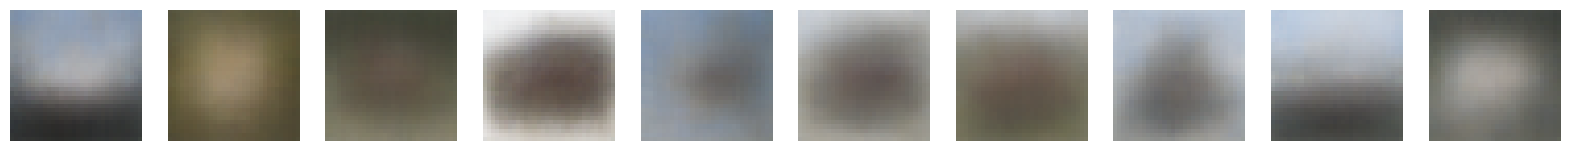

In [10]:
# Кількість зображень для генерації
n_to_generate = 10

# Генеруємо випадкові точки з Normal(0, 1)
z_sample = tf.random.normal(shape=(n_to_generate, latent_dim))

# Пропускаємо через декодер
generated_images = vae_model.decoder(z_sample)


# Функція для візуалізації
def plot_images(images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()


# Виведемо результат
plot_images(generated_images.numpy(), n=n_to_generate)

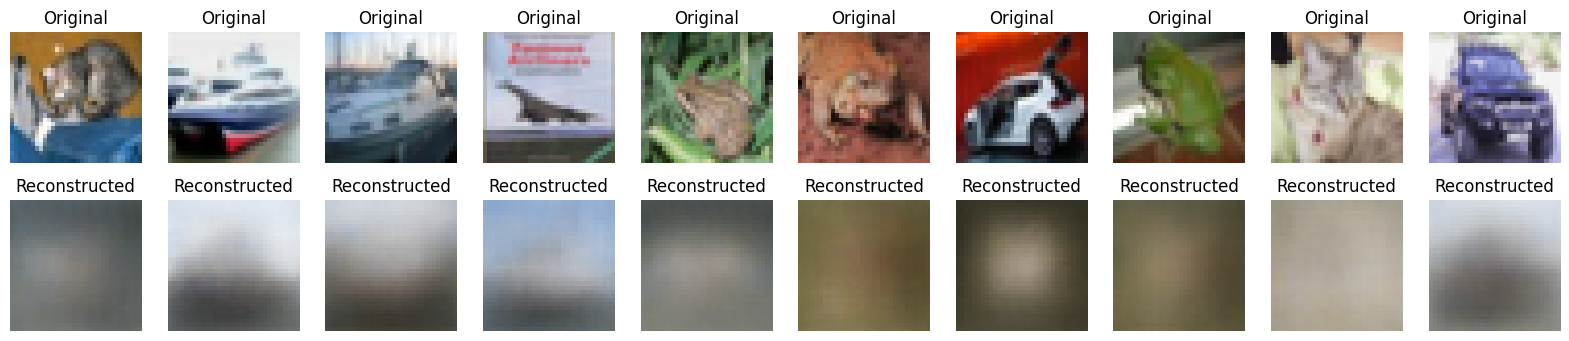

In [11]:
# Беремо перші 10 зображень з тесту
x_test_subset = x_test[:10]
mu, logvar, z = encoder(x_test_subset)
x_test_reconstructed = decoder(z)


# Відображаємо оригінали та реконструкції поруч
def plot_original_vs_recon(original, reconstructed):
    n = len(original)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Оригінали
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Реконструкція
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


plot_original_vs_recon(x_test_subset, x_test_reconstructed.numpy())

## Оптимізація

### Step 1

**Збільшимо мережу** (і глибину, і ширину) та **розмір латентного простору** у варіаційному автокодері (VAE) для CIFAR-10. Ідея полягає в тому, щоб:

1. **Додамо більше шарів Conv2D / Conv2DTranspose**.  
2. **Збільшимо кількість фільтрів** у кожному згортковому шарі (наприклад, 64 → 128).  
3. **Змінимо `latent_dim`** (наприклад, із 64 → 128 або 256).


In [12]:
latent_dim = 128  # Було 64, збільшили до 128
num_filters_encoder = [64, 128, 256]    # Різні рівні фільтрів в енкодері
num_filters_decoder = [256, 128, 64]    # Відповідно в декодері, але "навпаки"


In [13]:
# 1. Енкодер
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = encoder_inputs

# Додаємо більше шарів згортки, збільшуємо кількість фільтрів
for filters in num_filters_encoder:
    x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', activation='relu')(x)

# Сплющуємо
x = layers.Flatten()(x)
# Додаємо Dense
x = layers.Dense(512, activation='relu')(x)  # Ще один проміжний повнозв'язний шар
mu = layers.Dense(latent_dim, name='mu')(x)
logvar = layers.Dense(latent_dim, name='logvar')(x)

# Репараметризація
def sampling(args):
    mu, logvar = args
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * logvar) * epsilon

z = layers.Lambda(sampling, name='z')([mu, logvar])

encoder = keras.Model(encoder_inputs, [mu, logvar, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 64)   1792        ['input_3[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 8, 8, 128)    73856       ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 4, 4, 256)    295168      ['conv2d_3[0][0]']               
                                                                                            

In [14]:
# 2. Декодер
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4*4*num_filters_decoder[0], activation='relu')(latent_inputs)
x = layers.Reshape((4, 4, num_filters_decoder[0]))(x)

# Додаємо більше Conv2DTranspose, щоб відновити розмір 32x32
for filters in num_filters_decoder:
    x = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', activation='relu')(x)

# Через послідовні Conv2DTranspose ми, ймовірно, вийдемо за розмір 32x32,
# тому можемо додати ще один шар Conv2D, щоб привести вихід до (32, 32, 3).
x = layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder_outputs = x
decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 4096)              528384    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 256)        590080    
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 16, 16, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 64)       7379

In [15]:
# 3. Клас кастомного VAE (збільшений)
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        # Треки метрик
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs, training=None, mask=None):
        mu, logvar, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            mu, logvar, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Реконструктивна втрата (binary crossentropy або інша)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL-втрата
            kl_loss = 1 + logvar - tf.square(mu) - tf.exp(logvar)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }



In [16]:
vae_model = VAE(encoder, decoder)
def dummy_loss(y_true, y_pred):
    return 0.0

vae_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=dummy_loss)

In [17]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

vae_model.fit(
    x_train, x_train,  # Для автоенкодера "мітки" = ті ж вхідні дані
    epochs=50,  # Більше епох, тому що модель складніша
    batch_size=128,
    validation_data=(x_test, x_test),
)

Epoch 1/50
391/391 [==============================] - 8s 19ms/step - loss: 697.1387 - reconstruction_loss: 674.6464 - kl_loss: 5.4040 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/50
391/391 [==============================] - 6s 16ms/step - loss: 653.9224 - reconstruction_loss: 640.4091 - kl_loss: 12.0313 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/50
391/391 [==============================] - 6s 15ms/step - loss: 648.9419 - reconstruction_loss: 634.4041 - kl_loss: 13.3164 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/50
391/391 [==============================] - 6s 15ms/step - loss: 644.0035 - reconstruction_loss: 629.6245 - kl_loss: 13.0204 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/50
391/391 [==============================] - 6s 15ms/step - loss: 639.5445 - rec

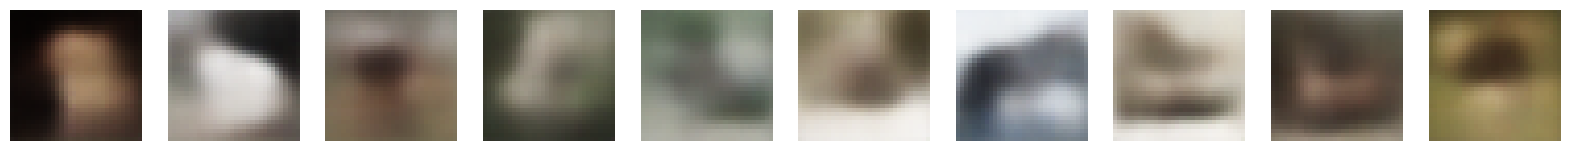

In [18]:
# Кількість зображень для генерації
n_to_generate = 10

# Генеруємо випадкові точки з Normal(0, 1)
z_sample = tf.random.normal(shape=(n_to_generate, latent_dim))

# Пропускаємо через декодер
generated_images = vae_model.decoder(z_sample)


# Функція для візуалізації
def plot_images(images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()


# Виведемо результат
plot_images(generated_images.numpy(), n=n_to_generate)

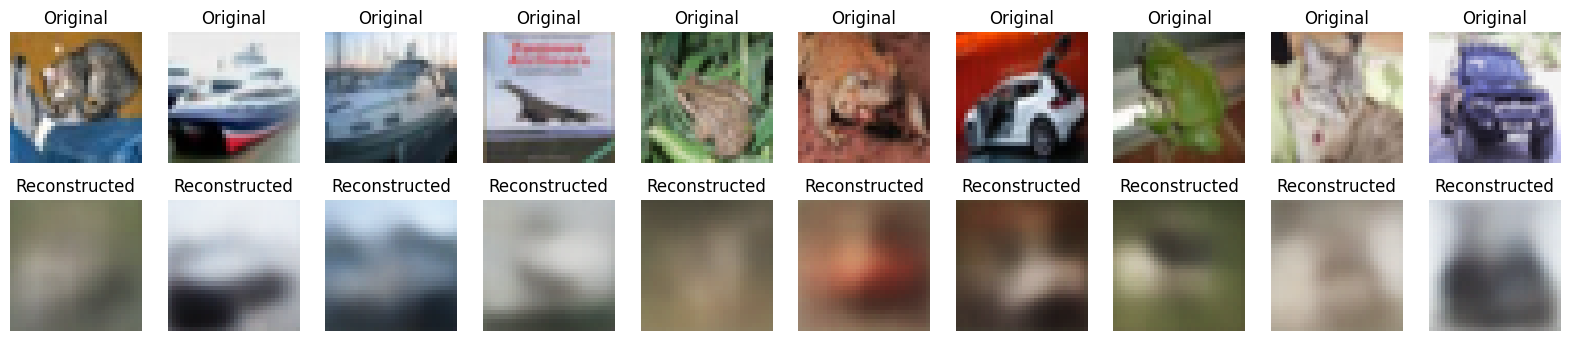

In [19]:
# Беремо перші 10 зображень з тесту
x_test_subset = x_test[:10]
mu, logvar, z = encoder(x_test_subset)
x_test_reconstructed = decoder(z)


# Відображаємо оригінали та реконструкції поруч
def plot_original_vs_recon(original, reconstructed):
    n = len(original)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Оригінали
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Реконструкція
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


plot_original_vs_recon(x_test_subset, x_test_reconstructed.numpy())

### Step 2

In [20]:
num_filters_encoder = [128, 256, 512, 512, 512] 
num_filters_decoder = [512, 512, 512, 256, 128] 
latent_dim = 512

In [21]:
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

print("x_train.shape =", x_train.shape)
print("x_test.shape  =", x_test.shape)

x_train.shape = (50000, 32, 32, 3)
x_test.shape  = (10000, 32, 32, 3)


In [22]:
########################################
# 2. Побудова енкодера
########################################
encoder_inputs = keras.Input(shape=(32, 32, 3))

x = encoder_inputs
for filters in num_filters_encoder:
    x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Після 5 блоків (strides=2 кожен раз) розмір зменшиться 32 -> 16 -> 8 -> 4 -> 2 -> 1

x = layers.Flatten()(x)
# Проміжний щільний шар
x = layers.Dense(1024, activation='relu')(x)

# Окремі вихідні шари для mu та logvar
mu = layers.Dense(latent_dim, name='mu')(x)
logvar = layers.Dense(latent_dim, name='logvar')(x)

# Функція для sampling (репараметризація)
def sampling(args):
    mu_, logvar_ = args
    epsilon = tf.random.normal(shape=tf.shape(mu_))
    return mu_ + tf.exp(0.5 * logvar_) * epsilon

z = layers.Lambda(sampling, name='z')([mu, logvar])

encoder = keras.Model(encoder_inputs, [mu, logvar, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 16, 16, 128)  3456        ['input_5[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 128)  512        ['conv2d_6[0][0]']               
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 16, 16, 128)  0           ['batch_normalization[0][0]

In [23]:
########################################
# 3. Побудова декодера
########################################
latent_inputs = keras.Input(shape=(latent_dim,))

# Декодуємо в 1×1×512 (або 2×2×512), залежить від того, який розмір був на виході енкодера.
# Якщо 5 блоків Conv2D(strides=2) скоротять 32×32 → 1×1 (при ідеальному діленні),
# то в декодері можна просто Reshape( (1,1,512) ).
# Якщо в процесі виникають проблеми з розмірами, можна перевірити,
# чи потрібно використати (2,2,512) і зробити strides=2 у меншій кількості блоків, тощо.

x = layers.Dense(1 * 1 * num_filters_decoder[0], activation='relu')(latent_inputs)
x = layers.Reshape((1, 1, num_filters_decoder[0]))(x)

# Тепер «розгортаємося» назад до 32×32
for filters in num_filters_decoder:
    x = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Поступово збільшиться: 1×1 → 2×2 → 4×4 → 8×8 → 16×16 → 32×32

# Завершальний шар на 3 канали
decoder_outputs = layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 512)]             0         
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 reshape_2 (Reshape)         (None, 1, 1, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 2, 2, 512)        2359296   
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 2, 2, 512)        2048      
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 2, 2, 512)         0   

In [27]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, alpha=0.5, **kwargs):
        """
        Параметр alpha визначає вагу для L1.
        Наприклад, якщо alpha=0.5, тоді:
          reconstruction_loss = 0.5 * MSE + 0.5 * L1
        """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, training=None, mask=None):
        mu_, logvar_, z_ = self.encoder(inputs)
        return self.decoder(z_)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            mu_, logvar_, z_ = self.encoder(data, training=True)
            reconstruction = self.decoder(z_, training=True)

            # ========= MSE part =========
            reconstruction_loss_mse = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1,2)  # msekra sum по (H,W)
                )
            )

            # ========= L1 part (MAE) =========
            reconstruction_loss_l1 = tf.reduce_mean(
                tf.reduce_sum(
                    tf.abs(data - reconstruction),
                    axis=(1,2,3)
                )
            )

            # Комбінація MSE + L1
            reconstruction_loss = (1.0 - self.alpha)*reconstruction_loss_mse + self.alpha*reconstruction_loss_l1

            # KL-втрата
            kl_loss = 1 + logvar_ - tf.square(mu_) - tf.exp(logvar_)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [28]:
# Створюємо модель
vae_model = VAE(encoder, decoder)

# Keras вимагає 'loss' при compile, навіть якщо ми його не використовуємо напряму
def dummy_loss(y_true, y_pred):
    return 0.0

vae_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=dummy_loss,
)


In [29]:
###############################################
# 4. Callback для виводу зображень кожні 10 епох
###############################################
class GenerateImagesCallback(keras.callbacks.Callback):
    def __init__(self, model, latent_dim=512, interval=10, n_images=5):
        """
        model: ваш VAE-об'єкт (що має .decoder)
        latent_dim: розмір латентного простору
        interval: виводити картинки кожні 'interval' епох
        n_images: скільки картинок генерувати
        """
        super().__init__()
        self.model = model
        self.latent_dim = latent_dim
        self.interval = interval
        self.n_images = n_images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            # Генеруємо випадкові z-вектори
            z_random = tf.random.normal(shape=(self.n_images, self.latent_dim))
            # Пропускаємо через декодер
            generated_images = self.model.decoder(z_random)

            # Виводимо
            print(f"\n[Callback] Згенеровані зображення після {epoch+1} епох:")
            plt.figure(figsize=(15,3))
            for i in range(self.n_images):
                ax = plt.subplot(1, self.n_images, i+1)
                plt.imshow(generated_images[i])
                plt.axis("off")
            plt.suptitle(f"Epoch {epoch+1}")
            plt.show()


Epoch 1/50
782/782 [==============================] - 19s 23ms/step - loss: 201.1900 - reconstruction_loss: 181.4169 - kl_loss: 19.3385 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/50
782/782 [==============================] - 16s 20ms/step - loss: 199.8408 - reconstruction_loss: 179.5036 - kl_loss: 19.6722 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/50
782/782 [==============================] - 16s 20ms/step - loss: 197.8501 - reconstruction_loss: 177.8097 - kl_loss: 19.8379 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/50
782/782 [==============================] - 16s 20ms/step - loss: 196.3161 - reconstruction_loss: 176.2833 - kl_loss: 20.0773 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/50
782/782 [==============================] - 16s 20ms/step - loss: 195.4615

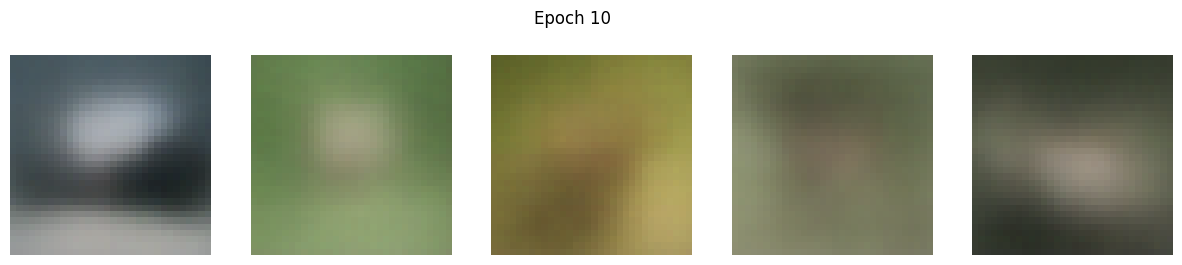

782/782 [==============================] - 16s 21ms/step - loss: 193.0516 - reconstruction_loss: 172.0658 - kl_loss: 21.0285 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 11/50
782/782 [==============================] - 16s 20ms/step - loss: 193.2852 - reconstruction_loss: 171.4623 - kl_loss: 21.0879 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 12/50
782/782 [==============================] - 16s 20ms/step - loss: 192.0406 - reconstruction_loss: 170.9275 - kl_loss: 21.1207 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 13/50
782/782 [==============================] - 16s 20ms/step - loss: 191.7754 - reconstruction_loss: 170.7614 - kl_loss: 21.1883 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 14/50
782/782 [==============================] - 16s 20ms/step - loss: 191.4623 - reco

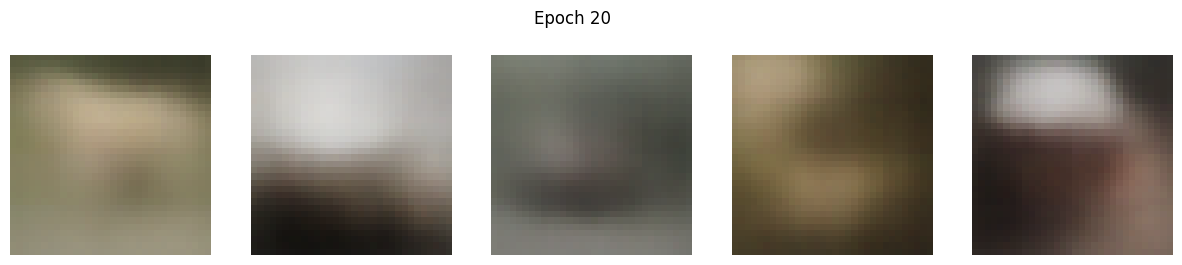

782/782 [==============================] - 16s 20ms/step - loss: 188.7111 - reconstruction_loss: 166.6434 - kl_loss: 22.1031 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 21/50
782/782 [==============================] - 15s 20ms/step - loss: 188.6098 - reconstruction_loss: 166.2826 - kl_loss: 22.1663 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 22/50
782/782 [==============================] - 15s 20ms/step - loss: 188.1465 - reconstruction_loss: 165.8260 - kl_loss: 22.2605 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 23/50
782/782 [==============================] - 15s 20ms/step - loss: 187.9088 - reconstruction_loss: 165.6558 - kl_loss: 22.3131 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 24/50
782/782 [==============================] - 16s 20ms/step - loss: 188.0225 - reco

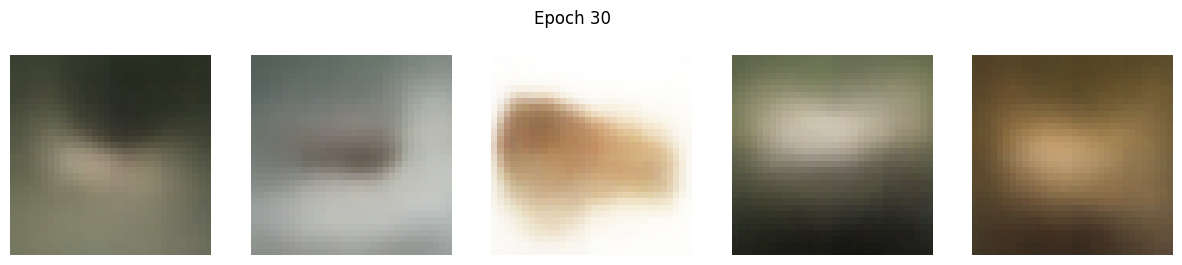

782/782 [==============================] - 16s 20ms/step - loss: 185.8942 - reconstruction_loss: 163.5235 - kl_loss: 22.7052 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 31/50
782/782 [==============================] - 16s 20ms/step - loss: 185.7117 - reconstruction_loss: 163.0625 - kl_loss: 22.8326 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 32/50
782/782 [==============================] - 16s 20ms/step - loss: 185.4722 - reconstruction_loss: 162.5944 - kl_loss: 22.8374 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 33/50
782/782 [==============================] - 16s 20ms/step - loss: 185.0293 - reconstruction_loss: 162.1730 - kl_loss: 22.9491 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 34/50
782/782 [==============================] - 16s 20ms/step - loss: 184.8109 - reco

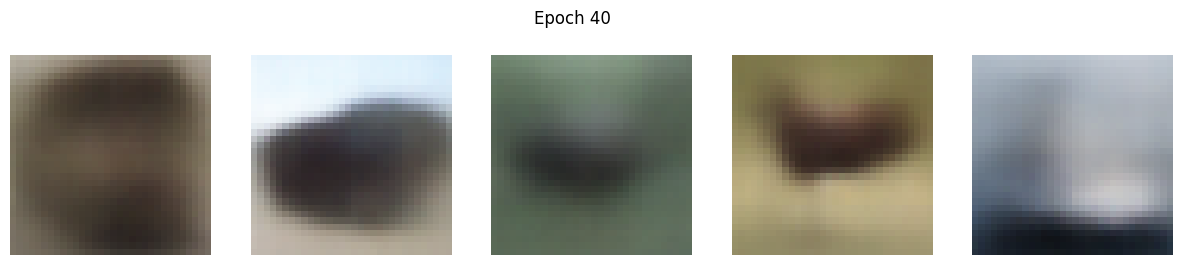

782/782 [==============================] - 16s 20ms/step - loss: 182.3566 - reconstruction_loss: 158.4267 - kl_loss: 23.8204 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 41/50
782/782 [==============================] - 16s 20ms/step - loss: 181.8356 - reconstruction_loss: 157.9473 - kl_loss: 24.0084 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 42/50
782/782 [==============================] - 16s 20ms/step - loss: 181.2301 - reconstruction_loss: 157.3816 - kl_loss: 24.0508 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 43/50
782/782 [==============================] - 15s 20ms/step - loss: 181.4310 - reconstruction_loss: 157.1480 - kl_loss: 24.1069 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 44/50
782/782 [==============================] - 15s 20ms/step - loss: 181.2162 - reco

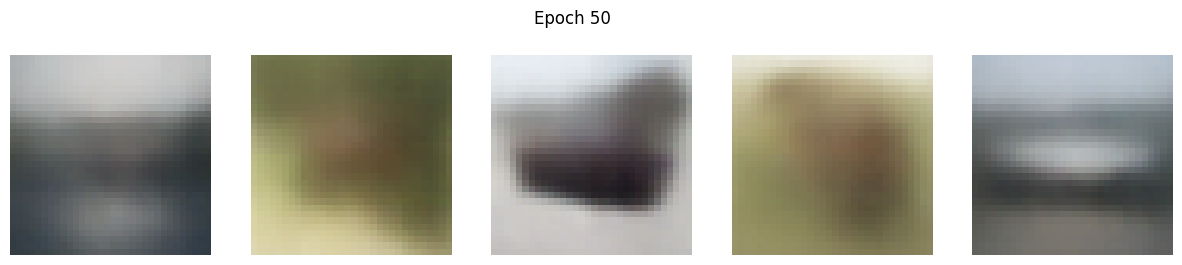

782/782 [==============================] - 16s 20ms/step - loss: 180.1059 - reconstruction_loss: 155.6931 - kl_loss: 24.4377 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00


In [30]:
########################################
# 5. Навчання
########################################
# Оскільки це автоенкодер, часто в якості "міток" для fit() подають ті ж x_train.
# Так само для валідації: (x_test, x_test).
# Якщо не хочете валідації, можна не вказувати або поставити None.
########################################
history = vae_model.fit(
    x_train, x_train,
    epochs=50,            
    batch_size=64,
    validation_data=(x_test, x_test),
    callbacks=[GenerateImagesCallback(vae_model, latent_dim=latent_dim, interval=10, n_images=5)]
)


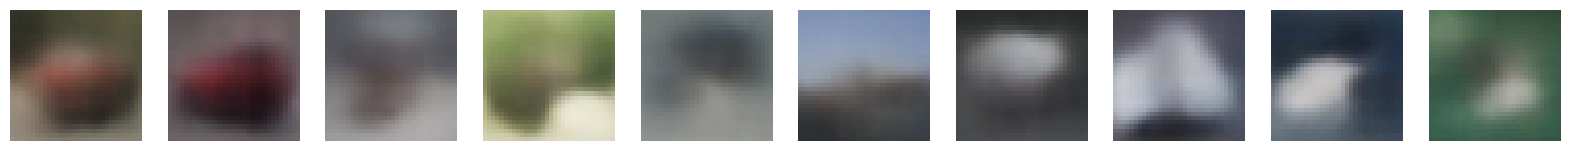

In [31]:
# Кількість зображень для генерації
n_to_generate = 10

# Генеруємо випадкові точки з Normal(0, 1)
z_sample = tf.random.normal(shape=(n_to_generate, latent_dim))

# Пропускаємо через декодер
generated_images = vae_model.decoder(z_sample)


# Функція для візуалізації
def plot_images(images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()


# Виведемо результат
plot_images(generated_images.numpy(), n=n_to_generate)

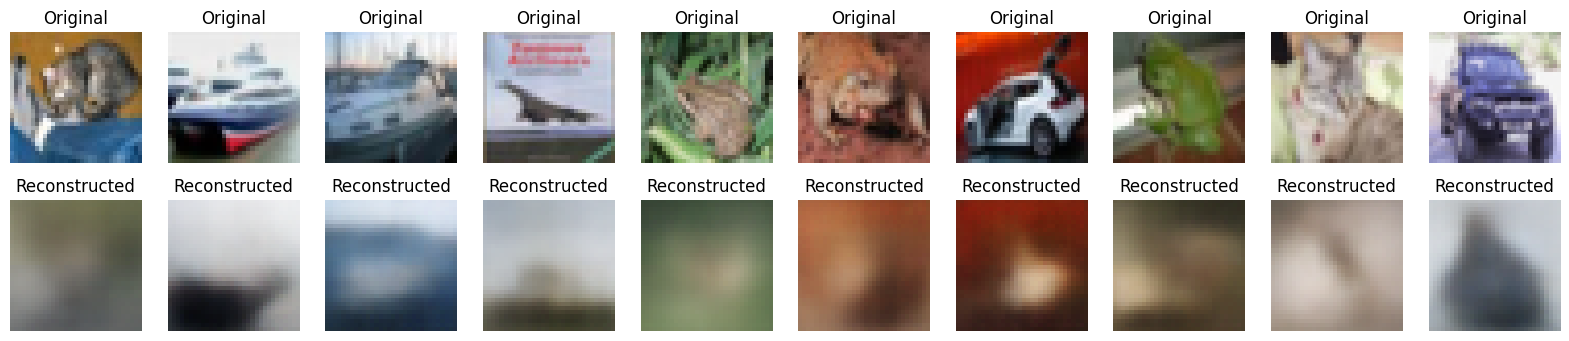

In [32]:
# Беремо перші 10 зображень з тесту
x_test_subset = x_test[:10]
mu, logvar, z = encoder(x_test_subset)
x_test_reconstructed = decoder(z)


# Відображаємо оригінали та реконструкції поруч
def plot_original_vs_recon(original, reconstructed):
    n = len(original)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Оригінали
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Реконструкція
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


plot_original_vs_recon(x_test_subset, x_test_reconstructed.numpy())

### Step 3

In [77]:
#############################################
# 1. Завантаження та підготовка даних CIFAR-10
#############################################
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0
print("x_train.shape =", x_train.shape, "x_test.shape =", x_test.shape)

x_train.shape = (50000, 32, 32, 3) x_test.shape = (10000, 32, 32, 3)


In [78]:
#############################################
# 2. Параметри архітектури
#############################################
latent_dim = 512  # Залишаємо 512, як ви просили

# Енкодер: 5 блоків (Conv -> BN -> ReLU -> strides=2)
# Кожен блок зберігатиме skip-вихід
num_filters_encoder = [128, 256, 512, 512, 512]

# Для декодера ми також робимо 5 блоків з Conv2DTranspose + concat + Conv
# - У місцях concat будемо додавати skip-зʼєднання
num_filters_decoder = [512, 512, 512, 256, 128]


In [79]:
#############################################
# 3. Енкодер (5 блоків, але 4 skip)
#############################################
def build_encoder(input_shape=(32, 32, 3), 
                  num_filters=[128, 256, 512, 512, 512], 
                  latent_dim=512):
    """
    - Робимо 5 блоків Conv->BN->ReLU (strides=2).
    - Skip-з'єднання беремо з перших 4-х.
    - П'ятий блок дає (1,1,512) -> Flatten -> Dense -> mu, logvar.
    """
    inputs = keras.Input(shape=input_shape)
    x = inputs

    skips = []
    num_blocks = len(num_filters)

    # Перших 4 блоки - збираємо skips
    for i in range(num_blocks - 1):
        filters = num_filters[i]
        x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        skips.append(x)  # зберігаємо проміжний вихід

    # 5-й блок (останній) - вже без skip
    filters = num_filters[-1]
    x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Тепер x ~ (1,1,512)

    x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)

    mu = layers.Dense(latent_dim, name='mu')(x)
    logvar = layers.Dense(latent_dim, name='logvar')(x)

    # Репараметризація
    def sampling(args):
        mu_, logvar_ = args
        epsilon = tf.random.normal(shape=tf.shape(mu_))
        return mu_ + tf.exp(0.5 * logvar_) * epsilon

    z = layers.Lambda(sampling, name='z')([mu, logvar])

    # Вихід: [mu, logvar, z] + список skip (4 штуки)
    outputs = [mu, logvar, z] + skips

    return keras.Model(inputs, outputs, name="encoder_fixed_skips")


In [80]:
#############################################
# 4. Декодер (4 рівні Conv2DTranspose + skip)
#############################################
def build_decoder(latent_dim=512, 
                  num_filters=[512, 512, 512, 256]):
    """
    Будемо приймати:
      - z_input
      - skip1..skip4 (форм 16×16, 8×8, 4×4, 2×2)
    Поступово збільшимо: (1,1) -> (2,2) -> (4,4) -> (8,8) -> (16,16) -> (32,32)
    """

    # Вхідні тензори
    z_input = keras.Input(shape=(latent_dim,), name="z_input")
    # 4 skip-и (в порядку, в якому вони додавалися)
    skip1 = keras.Input(shape=(16,16,128), name="skip1")  # з першого блоку
    skip2 = keras.Input(shape=(8,8,256),   name="skip2")
    skip3 = keras.Input(shape=(4,4,512),   name="skip3")
    skip4 = keras.Input(shape=(2,2,512),   name="skip4")  # з четвертого блоку

    # Базовий розмір після Dense
    x = layers.Dense(1*1*512, activation='relu')(z_input)
    x = layers.Reshape((1,1,512))(x)

    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 1) (1,1)->(2,2)
    x = layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # concat(skip4) (2,2,512)
    x = layers.Concatenate()([x, skip4])
    x = layers.Conv2D(512, kernel_size=3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 2) (2,2)->(4,4)
    x = layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # concat(skip3) (4,4,512)
    x = layers.Concatenate()([x, skip3])
    x = layers.Conv2D(512, kernel_size=3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3) (4,4)->(8,8)
    x = layers.Conv2DTranspose(512, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # concat(skip2) (8,8,256)
    x = layers.Concatenate()([x, skip2])
    x = layers.Conv2D(256, kernel_size=3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 4) (8,8)->(16,16)
    x = layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # concat(skip1) (16,16,128)
    x = layers.Concatenate()([x, skip1])
    x = layers.Conv2D(128, kernel_size=3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Фінальний крок: (16,16)->(32,32), без skip
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Вихід 3 канали (RGB)
    outputs = layers.Conv2D(3, kernel_size=3, padding='same', activation='sigmoid')(x)

    return keras.Model(
        inputs=[z_input, skip1, skip2, skip3, skip4],
        outputs=outputs,
        name="decoder_fixed_skips"
    )


In [81]:
#############################################
# 5. Створюємо енкодер і декодер
#############################################
encoder = build_encoder(
    input_shape=(32,32,3), 
    num_filters=num_filters_encoder,
    latent_dim=latent_dim
)
encoder.summary()

decoder = build_decoder(
    latent_dim=latent_dim, 
    num_filters=num_filters_decoder
)
decoder.summary()

Model: "encoder_fixed_skips"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_71 (Conv2D)             (None, 16, 16, 128)  3456        ['input_14[0][0]']               
                                                                                                  
 batch_normalization_99 (BatchN  (None, 16, 16, 128)  512        ['conv2d_71[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_99 (ReLU)                (None, 16, 16, 128)  0           ['batch_normali

In [82]:
#############################################
# 6. Клас VAE з кастомним train_step (MSE+L1)
#############################################
class VAE_U_Net(keras.Model):
    def __init__(self, encoder, decoder, alpha=0.5, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, training=None, mask=None):
        # Прямий прохід: отримуємо [mu, logvar, z, skip1..skip4], декодуємо
        outputs = self.encoder(inputs)
        mu_, logvar_, z_ = outputs[0], outputs[1], outputs[2]
        skip1, skip2, skip3, skip4 = outputs[3], outputs[4], outputs[5], outputs[6]

        reconstruction = self.decoder([z_, skip1, skip2, skip3, skip4])
        return reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]  # y = x

        with tf.GradientTape() as tape:
            encoder_out = self.encoder(data, training=True)
            mu_, logvar_, z_ = encoder_out[0], encoder_out[1], encoder_out[2]
            skip1, skip2, skip3, skip4 = encoder_out[3], encoder_out[4], encoder_out[5], encoder_out[6]

            reconstruction = self.decoder([z_, skip1, skip2, skip3, skip4], training=True)

            # ========= MSE part =========
            reconstruction_loss_mse = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1,2)
                )
            )

            # ========= L1 part (MAE) =========
            reconstruction_loss_l1 = tf.reduce_mean(
                tf.reduce_sum(
                    tf.abs(data - reconstruction),
                    axis=(1,2,3)
                )
            )

            # Комбінація
            reconstruction_loss = (1.0 - self.alpha)*reconstruction_loss_mse + self.alpha*reconstruction_loss_l1

            # KL-втрата
            kl_loss = 1 + logvar_ - tf.square(mu_) - tf.exp(logvar_)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [83]:
class ReconstructionCallback(keras.callbacks.Callback):
    def __init__(self, model, x_data, interval=10, n_images=5):
        """
        model: Ваш VAE-об'єкт (U-Net-подібний).
        x_data: Набір даних, з якого беруться приклади (наприклад, x_test).
        interval: Кожні 'interval' епох будемо візуалізувати.
        n_images: Скільки прикладів відобразити.
        """
        super().__init__()
        self.model = model
        self.x_data = x_data
        self.interval = interval
        self.n_images = n_images

    def on_epoch_end(self, epoch, logs=None):
        # Наприклад, кожні 10 епох
        if (epoch + 1) % self.interval == 0:
            # Візьмемо перші n_images або довільні:
            sample_images = self.x_data[:self.n_images]

            # Проганяємо через енкодер
            encoder_out = self.model.encoder(sample_images)
            z_sample = encoder_out[2]  # latent z
            skip1, skip2, skip3, skip4 = encoder_out[3], encoder_out[4], encoder_out[5], encoder_out[6]

            # Проганяємо через декодер
            reconstructed = self.model.decoder([z_sample, skip1, skip2, skip3, skip4])

            # Виводимо оригінал і реконструкцію поруч
            print(f"\n[Callback] Реконструкції після {epoch+1}-ї епохи:")
            plt.figure(figsize=(10, 4))
            for i in range(self.n_images):
                # Оригінал
                ax = plt.subplot(2, self.n_images, i+1)
                plt.imshow(sample_images[i])
                plt.title("Original")
                plt.axis('off')
                
                # Реконструкція
                ax = plt.subplot(2, self.n_images, self.n_images + i + 1)
                plt.imshow(reconstructed[i])
                plt.title("Reconstructed")
                plt.axis('off')

            plt.tight_layout()
            plt.show()

Epoch 1/50
782/782 [==============================] - 23s 28ms/step - loss: 87.7505 - reconstruction_loss: 53.2058 - kl_loss: 1.2224 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/50
782/782 [==============================] - 21s 26ms/step - loss: 36.6995 - reconstruction_loss: 34.8612 - kl_loss: 0.0036 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/50
782/782 [==============================] - 21s 26ms/step - loss: 31.3923 - reconstruction_loss: 31.0171 - kl_loss: 0.0021 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/50
782/782 [==============================] - 21s 26ms/step - loss: 28.4966 - reconstruction_loss: 27.9959 - kl_loss: 7.2848e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/50
782/782 [==============================] - ETA: 0s - loss: 27.1840 - reconstructi

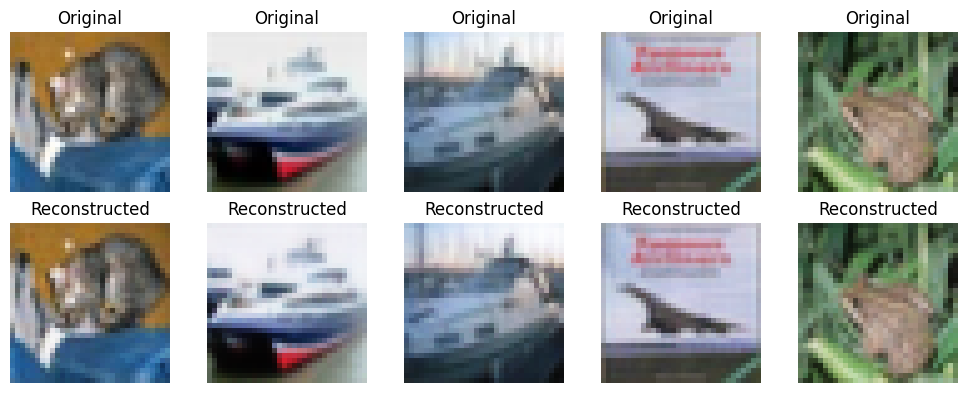

782/782 [==============================] - 21s 27ms/step - loss: 27.1834 - reconstruction_loss: 26.7661 - kl_loss: 7.3616e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 6/50
782/782 [==============================] - 21s 27ms/step - loss: 25.4374 - reconstruction_loss: 25.1395 - kl_loss: 3.6415e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 7/50
782/782 [==============================] - 21s 26ms/step - loss: 24.0163 - reconstruction_loss: 23.8237 - kl_loss: 2.7817e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 8/50
782/782 [==============================] - 21s 26ms/step - loss: 21.8182 - reconstruction_loss: 21.9288 - kl_loss: 0.0011 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 9/50
782/782 [==============================] - 21s 27ms/step - loss: 21.6408 - reconstru

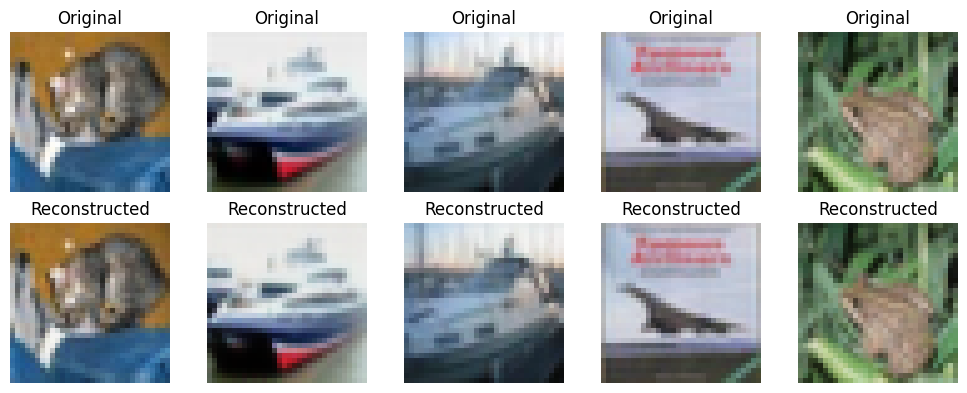

782/782 [==============================] - 21s 27ms/step - loss: 20.6805 - reconstruction_loss: 20.2769 - kl_loss: 6.0957e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 11/50
782/782 [==============================] - 21s 26ms/step - loss: 19.6133 - reconstruction_loss: 19.4958 - kl_loss: 3.6132e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 12/50
782/782 [==============================] - 21s 26ms/step - loss: 19.2829 - reconstruction_loss: 18.8446 - kl_loss: 5.2961e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 13/50
782/782 [==============================] - 21s 26ms/step - loss: 18.3678 - reconstruction_loss: 18.2313 - kl_loss: 6.0190e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 14/50
782/782 [==============================] - 21s 26ms/step - loss: 17.8902 - r

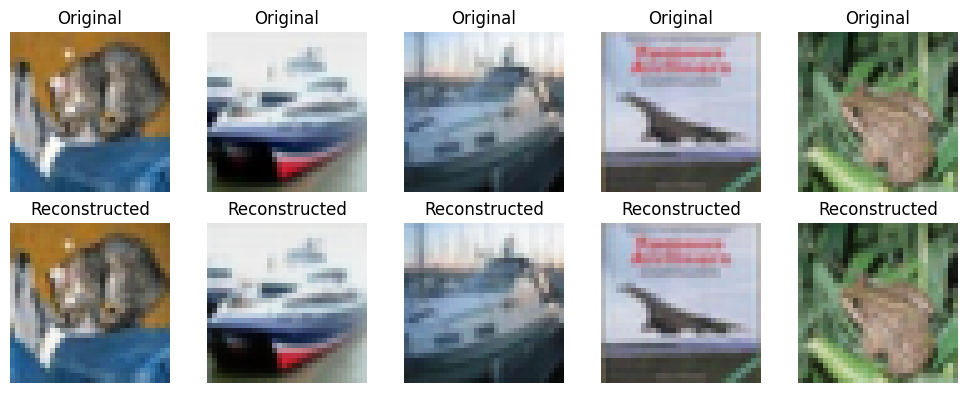

782/782 [==============================] - 21s 27ms/step - loss: 17.0100 - reconstruction_loss: 16.9944 - kl_loss: 2.7233e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 16/50
782/782 [==============================] - 21s 26ms/step - loss: 16.2148 - reconstruction_loss: 16.4448 - kl_loss: 5.7589e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 17/50
782/782 [==============================] - 21s 26ms/step - loss: 16.0966 - reconstruction_loss: 16.5689 - kl_loss: 2.5607e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 18/50
782/782 [==============================] - 20s 26ms/step - loss: 15.6755 - reconstruction_loss: 15.5737 - kl_loss: 6.9281e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 19/50
782/782 [==============================] - 21s 26ms/step - loss: 15.5979 - r

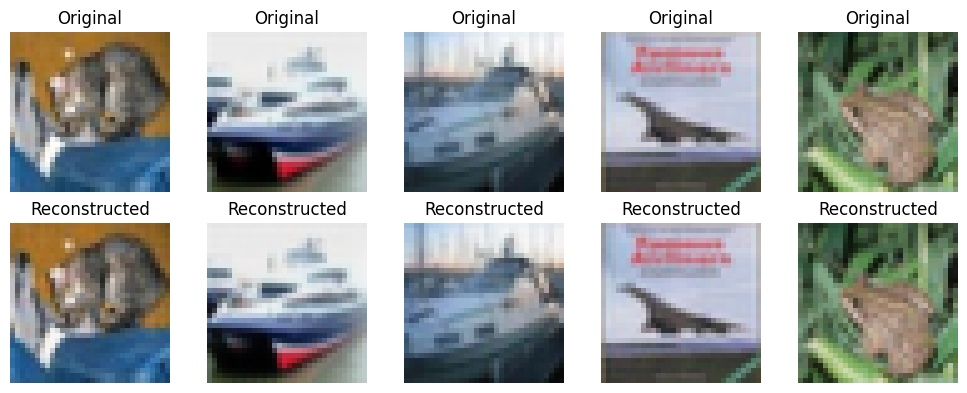

782/782 [==============================] - 21s 27ms/step - loss: 15.1946 - reconstruction_loss: 15.4512 - kl_loss: 6.1625e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 21/50
782/782 [==============================] - 20s 26ms/step - loss: 15.1149 - reconstruction_loss: 14.6189 - kl_loss: 4.6859e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 22/50
782/782 [==============================] - 21s 26ms/step - loss: 14.8316 - reconstruction_loss: 14.9658 - kl_loss: 5.9139e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 23/50
782/782 [==============================] - 21s 26ms/step - loss: 14.6383 - reconstruction_loss: 14.8460 - kl_loss: 4.1814e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 24/50
782/782 [==============================] - 21s 26ms/step - loss: 14.3121 - r

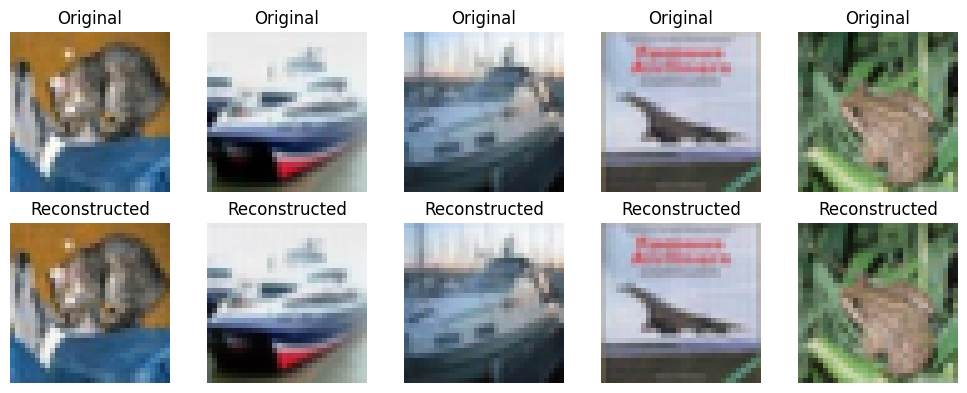

782/782 [==============================] - 21s 27ms/step - loss: 13.6953 - reconstruction_loss: 13.4586 - kl_loss: 1.2241e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 26/50
782/782 [==============================] - 21s 27ms/step - loss: 14.0338 - reconstruction_loss: 13.9276 - kl_loss: 2.5515e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 27/50
782/782 [==============================] - 21s 26ms/step - loss: 13.6784 - reconstruction_loss: 13.6723 - kl_loss: 3.2362e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 28/50
782/782 [==============================] - 21s 27ms/step - loss: 12.9115 - reconstruction_loss: 12.8270 - kl_loss: 4.1271e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 29/50
782/782 [==============================] - 21s 26ms/step - loss: 13.8205 - r

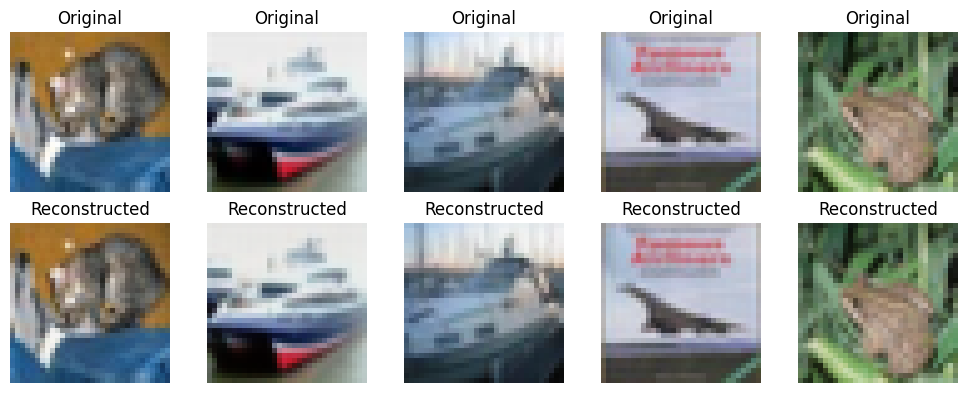

782/782 [==============================] - 21s 27ms/step - loss: 12.8436 - reconstruction_loss: 12.7550 - kl_loss: 2.2961e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 31/50
782/782 [==============================] - 21s 27ms/step - loss: 12.9718 - reconstruction_loss: 12.8878 - kl_loss: 1.8843e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 32/50
782/782 [==============================] - 21s 26ms/step - loss: 12.3147 - reconstruction_loss: 12.3294 - kl_loss: 1.3837e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 33/50
782/782 [==============================] - 21s 27ms/step - loss: 12.7476 - reconstruction_loss: 12.2858 - kl_loss: 3.3539e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 34/50
782/782 [==============================] - 21s 27ms/step - loss: 12.0789 - r

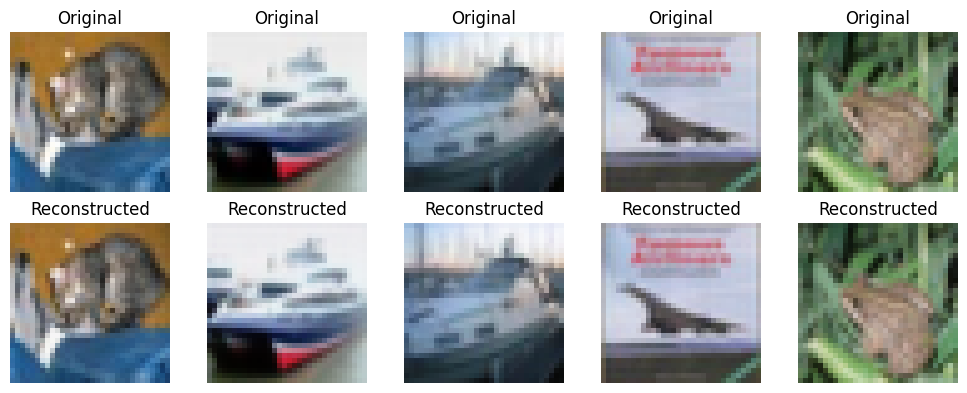

782/782 [==============================] - 21s 27ms/step - loss: 11.5628 - reconstruction_loss: 11.6631 - kl_loss: 2.6115e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 36/50
782/782 [==============================] - 21s 26ms/step - loss: 12.0069 - reconstruction_loss: 11.9756 - kl_loss: 3.2593e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 37/50
782/782 [==============================] - 21s 26ms/step - loss: 11.4885 - reconstruction_loss: 11.6407 - kl_loss: 2.3605e-04 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 38/50
782/782 [==============================] - 21s 26ms/step - loss: 11.6831 - reconstruction_loss: 11.5731 - kl_loss: 3.1697e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 39/50
782/782 [==============================] - 21s 27ms/step - loss: 11.7777 - r

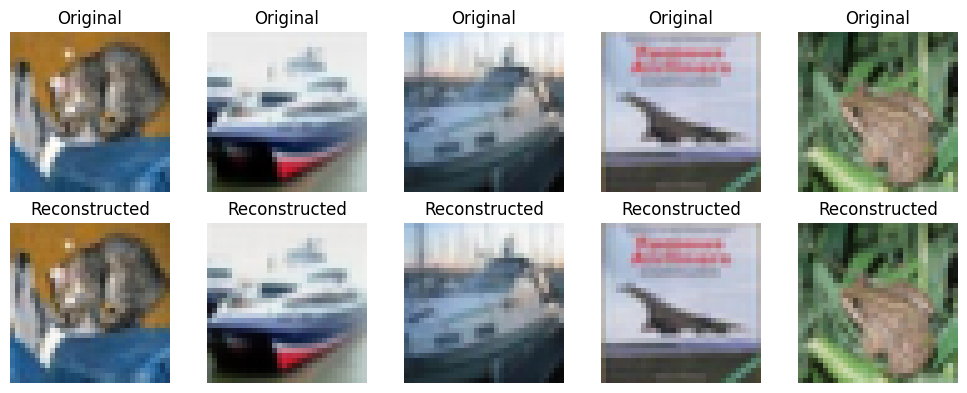

782/782 [==============================] - 21s 27ms/step - loss: 11.4625 - reconstruction_loss: 11.3346 - kl_loss: 9.7062e-06 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 41/50
782/782 [==============================] - 21s 26ms/step - loss: 10.9733 - reconstruction_loss: 11.1708 - kl_loss: 1.2158e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 42/50
782/782 [==============================] - 21s 26ms/step - loss: 10.9378 - reconstruction_loss: 11.1802 - kl_loss: 2.4084e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 43/50
782/782 [==============================] - 21s 26ms/step - loss: 10.9519 - reconstruction_loss: 10.7890 - kl_loss: 2.3921e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 44/50
782/782 [==============================] - 21s 27ms/step - loss: 12.1185 - r

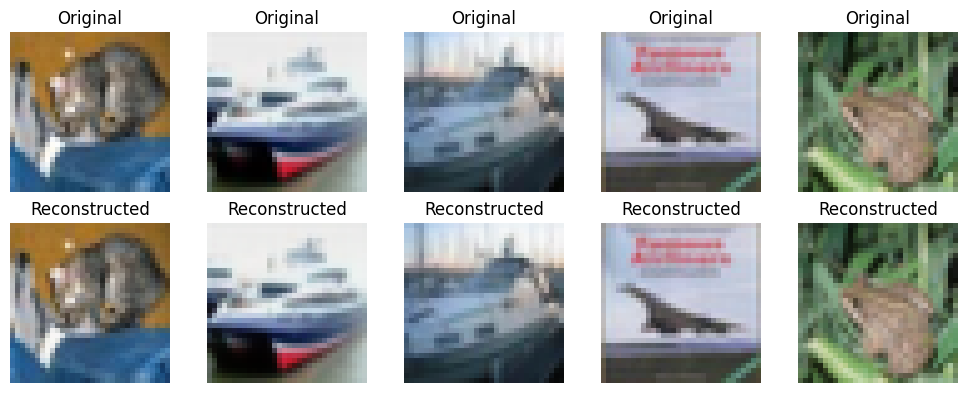

782/782 [==============================] - 21s 27ms/step - loss: 10.7187 - reconstruction_loss: 10.7916 - kl_loss: 1.9629e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 46/50
782/782 [==============================] - 21s 27ms/step - loss: 10.1783 - reconstruction_loss: 10.5136 - kl_loss: 1.6579e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 47/50
782/782 [==============================] - 21s 26ms/step - loss: 11.1317 - reconstruction_loss: 10.6719 - kl_loss: 1.8856e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 48/50
782/782 [==============================] - 21s 26ms/step - loss: 10.3762 - reconstruction_loss: 10.4468 - kl_loss: 1.1705e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 49/50
782/782 [==============================] - 20s 26ms/step - loss: 10.2096 - r

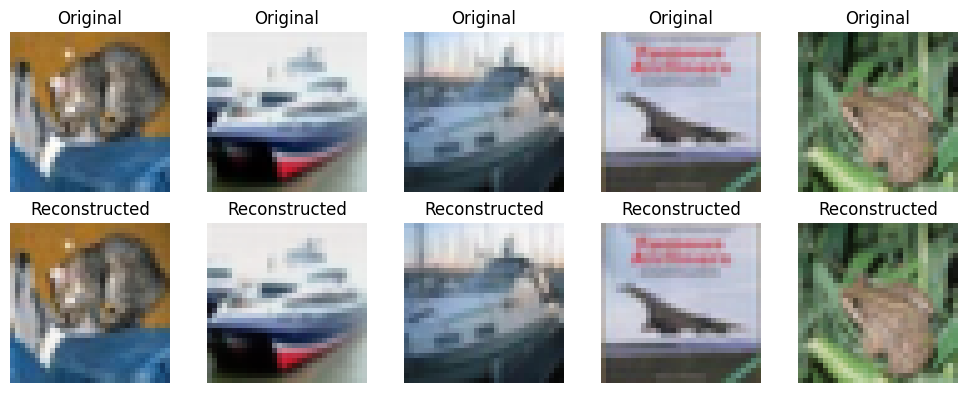

782/782 [==============================] - 21s 26ms/step - loss: 10.3009 - reconstruction_loss: 10.4311 - kl_loss: 3.1225e-05 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00


In [84]:
#############################################
# 7. Створюємо й навчаємо
#############################################
vae_model = VAE_U_Net(encoder, decoder, alpha=0.5)

def dummy_loss(y_true, y_pred):
    return 0.0

vae_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=dummy_loss
)

history = vae_model.fit(
    x_train, x_train,
    epochs=50,            
    batch_size=64,
    validation_data=(x_test, x_test),
    callbacks=[
        ReconstructionCallback(
            model=vae_model,
            x_data=x_test,      # Звідки беремо картинки для перевірки
            interval=5,        # Відображати кожні 10 епох
            n_images=5          # Скільки картинок відобразити
        )
    ]
)

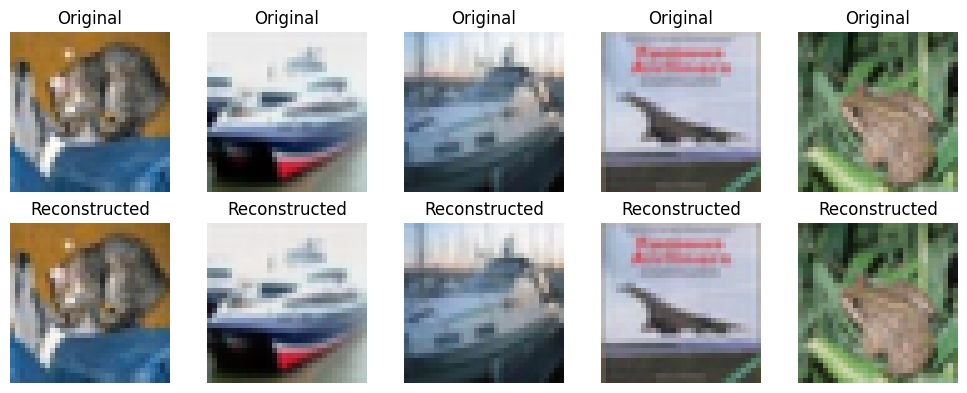

In [85]:
#############################################
# 8. Демонстрація реконструкцій
#############################################
import numpy as np

sample_images = x_test[:5]
encoder_out = vae_model.encoder(sample_images)
z_sample = encoder_out[2]  # latent
skip1, skip2, skip3, skip4 = encoder_out[3], encoder_out[4], encoder_out[5], encoder_out[6]

reconstructed = vae_model.decoder([z_sample, skip1, skip2, skip3, skip4])

plt.figure(figsize=(10,4))
for i in range(5):
    # Original
    ax = plt.subplot(2,5,i+1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis('off')
    
    # Reconstructed
    ax = plt.subplot(2,5,5+i+1)
    plt.imshow(reconstructed[i])
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

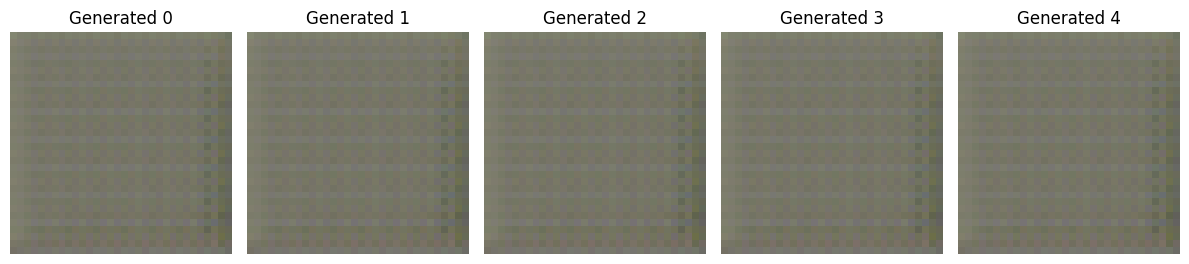

In [86]:
# Припустимо, ви вже навчили модель vae_model (VAE_U_Net),
# у якій latent_dim = 512 і декодер очікує 5 входів: 
#  [z, skip1, skip2, skip3, skip4].

# 1) Формуємо випадковий z
n_to_generate = 5
z_random = tf.random.normal(shape=(n_to_generate, 512))

# 2) Створюємо "порожні" (нулові) skip-тензори потрібних розмірів.
#   - форма skip1 -> (None, 16, 16, 128)
#   - форма skip2 -> (None, 8, 8, 256)
#   - форма skip3 -> (None, 4, 4, 512)
#   - форма skip4 -> (None, 2, 2, 512)
skip1_zeros = tf.zeros((n_to_generate, 16, 16, 128), dtype=tf.float32)
skip2_zeros = tf.zeros((n_to_generate, 8, 8, 256), dtype=tf.float32)
skip3_zeros = tf.zeros((n_to_generate, 4, 4, 512), dtype=tf.float32)
skip4_zeros = tf.zeros((n_to_generate, 2, 2, 512), dtype=tf.float32)

# 3) «Чиста» генерація:
generated_images = vae_model.decoder(
    [z_random, skip1_zeros, skip2_zeros, skip3_zeros, skip4_zeros]
)

# 4) Візуалізуємо
plt.figure(figsize=(12,3))
for i in range(n_to_generate):
    ax = plt.subplot(1, n_to_generate, i+1)
    plt.imshow(generated_images[i])
    plt.title(f"Generated {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()

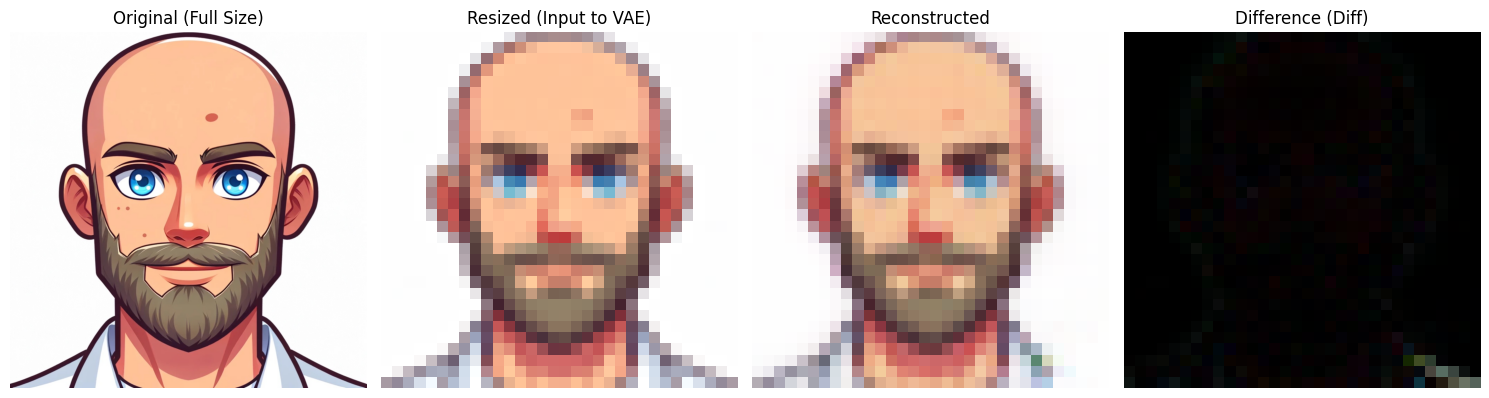

In [90]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Завантаження довільного зображення
image_path = "a_small.jpg"  # Змініть на шлях до вашого зображення
original_image = load_img(image_path)

image = original_image.resize((32, 32))  # Змінюємо розмір до 32x32
image_array = img_to_array(image) / 255.0  # Нормалізація в [0,1]
image_array = np.expand_dims(image_array, axis=0)  # Додаємо batch dimension

# Реконструкція
encoder_out = vae_model.encoder(image_array)
z_sample = encoder_out[2]  # латентний вектор
skip1, skip2, skip3, skip4 = encoder_out[3], encoder_out[4], encoder_out[5], encoder_out[6]

reconstructed = vae_model.decoder([z_sample, skip1, skip2, skip3, skip4])

# Обчислення різниці (diff)
diff = np.abs(image_array[0] - reconstructed[0])

# Візуалізація
plt.figure(figsize=(15, 5))

# Оригінал (повнорозмірне зображення)
plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title("Original (Full Size)")
plt.axis('off')

# Resized (вхід моделі)
plt.subplot(1, 4, 2)
plt.imshow(image_array[0])
plt.title("Resized (Input to VAE)")
plt.axis('off')

# Реконструкція
plt.subplot(1, 4, 3)
plt.imshow(reconstructed[0])
plt.title("Reconstructed")
plt.axis('off')

# Різниця (diff)
plt.subplot(1, 4, 4)
plt.imshow(diff)
plt.title("Difference (Diff)")
plt.axis('off')

plt.tight_layout()
plt.show()

### Step 4 (on Step 2)

In [100]:
import tensorflow_addons as tfa

In [101]:
num_filters_encoder = [128, 256, 512, 512, 512]
num_filters_decoder = [512, 512, 512, 256, 128]
latent_dim = 1024

In [102]:
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

print("x_train.shape =", x_train.shape)
print("x_test.shape  =", x_test.shape)

x_train.shape = (50000, 32, 32, 3)
x_test.shape  = (10000, 32, 32, 3)


In [103]:
########################################
# 2. Побудова енкодера
########################################
encoder_inputs = keras.Input(shape=(32, 32, 3))

x = encoder_inputs
for filters in num_filters_encoder:
    x = layers.Conv2D(filters, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    # Після 5 блоків (strides=2 кожен раз) розмір зменшиться 32 -> 16 -> 8 -> 4 -> 2 -> 1

x = layers.Flatten()(x)
# Проміжний щільний шар
x = layers.Dense(1024, activation='relu')(x)

# Окремі вихідні шари для mu та logvar
mu = layers.Dense(latent_dim, name='mu')(x)
logvar = layers.Dense(latent_dim, name='logvar')(x)

# Функція для sampling (репараметризація)
def sampling(args):
    mu_, logvar_ = args
    epsilon = tf.random.normal(shape=tf.shape(mu_))
    return mu_ + tf.exp(0.5 * logvar_) * epsilon

z = layers.Lambda(sampling, name='z')([mu, logvar])

encoder = keras.Model(encoder_inputs, [mu, logvar, z], name='encoder')
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_86 (Conv2D)             (None, 16, 16, 128)  3456        ['input_17[0][0]']               
                                                                                                  
 batch_normalization_124 (Batch  (None, 16, 16, 128)  512        ['conv2d_86[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu_124 (ReLU)               (None, 16, 16, 128)  0           ['batch_normalization_124[0

In [104]:
########################################
# 3. Побудова декодера
########################################
latent_inputs = keras.Input(shape=(latent_dim,))

# Декодуємо в 1×1×512 (або 2×2×512), залежить від того, який розмір був на виході енкодера.
# Якщо 5 блоків Conv2D(strides=2) скоротять 32×32 → 1×1 (при ідеальному діленні),
# то в декодері можна просто Reshape( (1,1,512) ).
# Якщо в процесі виникають проблеми з розмірами, можна перевірити,
# чи потрібно використати (2,2,512) і зробити strides=2 у меншій кількості блоків, тощо.

x = layers.Dense(1 * 1 * num_filters_decoder[0], activation='relu')(latent_inputs)
x = layers.Reshape((1, 1, num_filters_decoder[0]))(x)

# Тепер «розгортаємося» назад до 32×32
for filters in num_filters_decoder:
    x = layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    # Поступово збільшиться: 1×1 → 2×2 → 4×4 → 8×8 → 16×16 → 32×32

# Завершальний шар на 3 канали
decoder_outputs = layers.Conv2DTranspose(3, kernel_size=3, padding='same', activation='sigmoid')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 reshape_12 (Reshape)        (None, 1, 1, 512)         0         
                                                                 
 conv2d_transpose_50 (Conv2D  (None, 2, 2, 512)        2359296   
 Transpose)                                                      
                                                                 
 batch_normalization_129 (Ba  (None, 2, 2, 512)        2048      
 tchNormalization)                                               
                                                                 
 re_lu_129 (ReLU)            (None, 2, 2, 512)         0   

In [105]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, alpha=0.5, **kwargs):
        """
        Параметр alpha визначає вагу для L1.
        Наприклад, якщо alpha=0.5, тоді:
          reconstruction_loss = 0.5 * MSE + 0.5 * L1
        """
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.alpha = alpha

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs, training=None, mask=None):
        mu_, logvar_, z_ = self.encoder(inputs)
        return self.decoder(z_)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            mu_, logvar_, z_ = self.encoder(data, training=True)
            reconstruction = self.decoder(z_, training=True)

            # ========= MSE part =========
            reconstruction_loss_mse = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1,2)  # msekra sum по (H,W)
                )
            )

            # ========= L1 part (MAE) =========
            reconstruction_loss_l1 = tf.reduce_mean(
                tf.reduce_sum(
                    tf.abs(data - reconstruction),
                    axis=(1,2,3)
                )
            )

            # Комбінація MSE + L1
            reconstruction_loss = (1.0 - self.alpha)*reconstruction_loss_mse + self.alpha*reconstruction_loss_l1

            # KL-втрата
            kl_loss = 1 + logvar_ - tf.square(mu_) - tf.exp(logvar_)
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [106]:
# Створюємо модель
vae_model = VAE(encoder, decoder)

initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=5000,  # Поступове зменшення протягом кількох кроків
    end_learning_rate=1e-6
)

optimizer = tfa.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4  # Регуляризація ваг
)

vae_model.compile(optimizer=optimizer, loss=lambda y_true, y_pred: 0.0)


In [107]:
###############################################
# 4. Callback для виводу зображень кожні 10 епох
###############################################
class GenerateImagesCallback(keras.callbacks.Callback):
    def __init__(self, model, latent_dim=512, interval=10, n_images=5):
        """
        model: ваш VAE-об'єкт (що має .decoder)
        latent_dim: розмір латентного простору
        interval: виводити картинки кожні 'interval' епох
        n_images: скільки картинок генерувати
        """
        super().__init__()
        self.model = model
        self.latent_dim = latent_dim
        self.interval = interval
        self.n_images = n_images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            # Генеруємо випадкові z-вектори
            z_random = tf.random.normal(shape=(self.n_images, self.latent_dim))
            # Пропускаємо через декодер
            generated_images = self.model.decoder(z_random)

            # Виводимо
            print(f"\n[Callback] Згенеровані зображення після {epoch+1} епох:")
            plt.figure(figsize=(15,3))
            for i in range(self.n_images):
                ax = plt.subplot(1, self.n_images, i+1)
                plt.imshow(generated_images[i])
                plt.axis("off")
            plt.suptitle(f"Epoch {epoch+1}")
            plt.show()


Epoch 1/500
49/49 [==============================] - 8s 127ms/step - loss: 457.2730 - reconstruction_loss: 358.7867 - kl_loss: 38.1997 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/500
49/49 [==============================] - 5s 107ms/step - loss: 350.6950 - reconstruction_loss: 349.1362 - kl_loss: 1.0763 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/500
49/49 [==============================] - 5s 108ms/step - loss: 349.5801 - reconstruction_loss: 349.0051 - kl_loss: 0.4703 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/500
49/49 [==============================] - 5s 109ms/step - loss: 349.1997 - reconstruction_loss: 348.9670 - kl_loss: 0.3158 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/500
49/49 [==============================] - 5s 107ms/step - loss: 348.8928 - recon

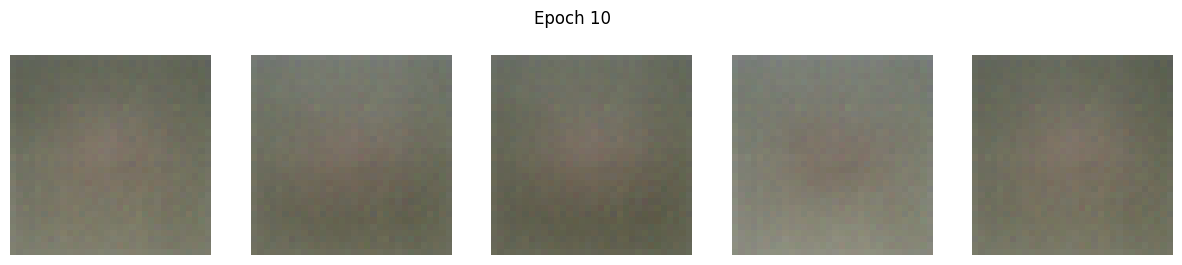

49/49 [==============================] - 5s 111ms/step - loss: 274.4035 - reconstruction_loss: 262.9992 - kl_loss: 10.9863 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 11/500
49/49 [==============================] - 5s 108ms/step - loss: 272.6898 - reconstruction_loss: 262.0010 - kl_loss: 10.7930 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 12/500
49/49 [==============================] - 5s 107ms/step - loss: 272.5471 - reconstruction_loss: 261.4814 - kl_loss: 10.6753 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 13/500
49/49 [==============================] - 5s 108ms/step - loss: 271.7436 - reconstruction_loss: 261.1068 - kl_loss: 10.5992 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 14/500
49/49 [==============================] - 5s 108ms/step - loss: 271.2230 - reconstruc

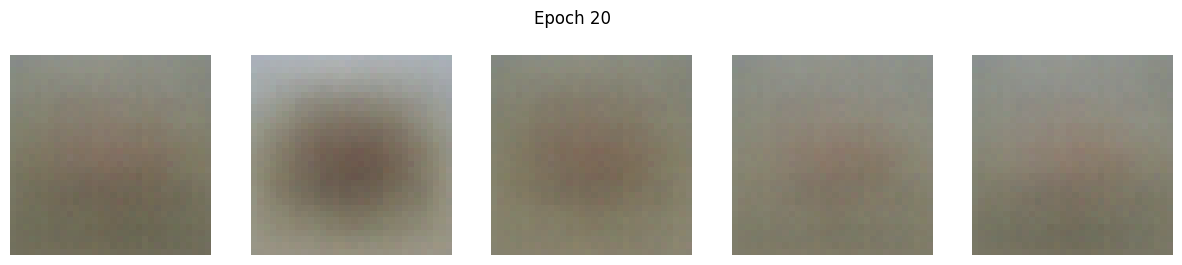

49/49 [==============================] - 6s 113ms/step - loss: 260.0553 - reconstruction_loss: 246.5578 - kl_loss: 13.2388 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 21/500
49/49 [==============================] - 5s 109ms/step - loss: 259.1288 - reconstruction_loss: 245.9082 - kl_loss: 13.1416 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 22/500
49/49 [==============================] - 5s 108ms/step - loss: 258.6262 - reconstruction_loss: 245.5056 - kl_loss: 13.1438 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 23/500
49/49 [==============================] - 5s 108ms/step - loss: 258.5868 - reconstruction_loss: 245.2324 - kl_loss: 13.2158 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 24/500
49/49 [==============================] - 5s 108ms/step - loss: 258.3151 - reconstruc

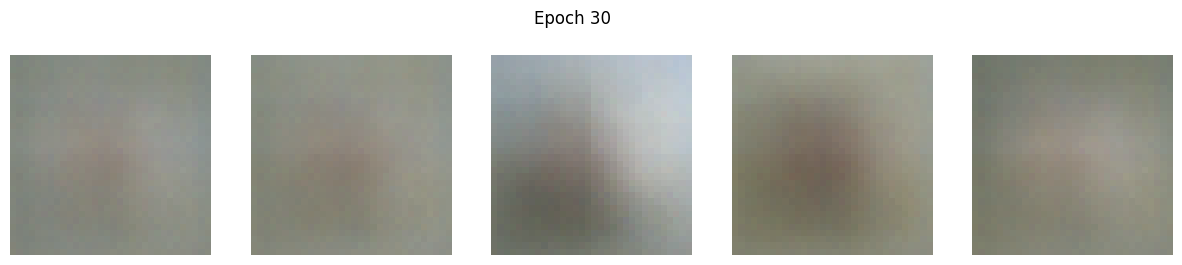

49/49 [==============================] - 6s 113ms/step - loss: 252.9585 - reconstruction_loss: 237.3591 - kl_loss: 15.1286 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 31/500
49/49 [==============================] - 5s 108ms/step - loss: 252.6863 - reconstruction_loss: 236.7339 - kl_loss: 15.2525 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 32/500
49/49 [==============================] - 5s 108ms/step - loss: 251.3741 - reconstruction_loss: 235.8785 - kl_loss: 15.3341 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 33/500
49/49 [==============================] - 5s 108ms/step - loss: 251.0921 - reconstruction_loss: 235.0496 - kl_loss: 15.4915 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 34/500
49/49 [==============================] - 5s 108ms/step - loss: 249.7149 - reconstruc

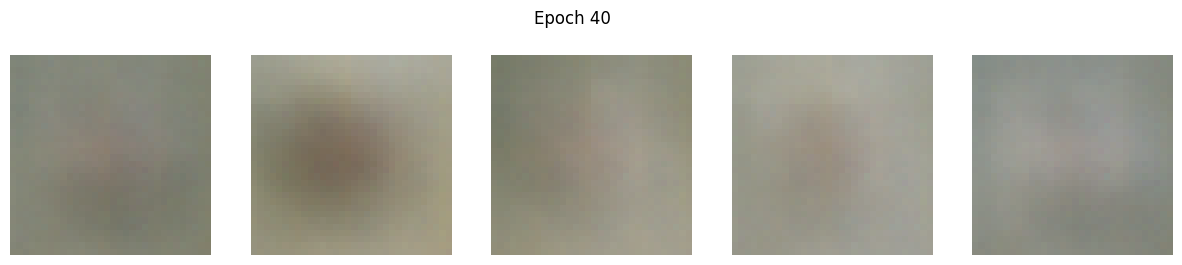

49/49 [==============================] - 6s 112ms/step - loss: 244.1795 - reconstruction_loss: 227.1946 - kl_loss: 17.0332 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 41/500
49/49 [==============================] - 5s 109ms/step - loss: 243.2675 - reconstruction_loss: 226.0913 - kl_loss: 17.2989 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 42/500
49/49 [==============================] - 5s 108ms/step - loss: 242.1987 - reconstruction_loss: 224.5511 - kl_loss: 17.6971 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 43/500
49/49 [==============================] - 5s 109ms/step - loss: 241.6370 - reconstruction_loss: 223.3491 - kl_loss: 18.0653 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 44/500
49/49 [==============================] - 5s 109ms/step - loss: 240.7751 - reconstruc

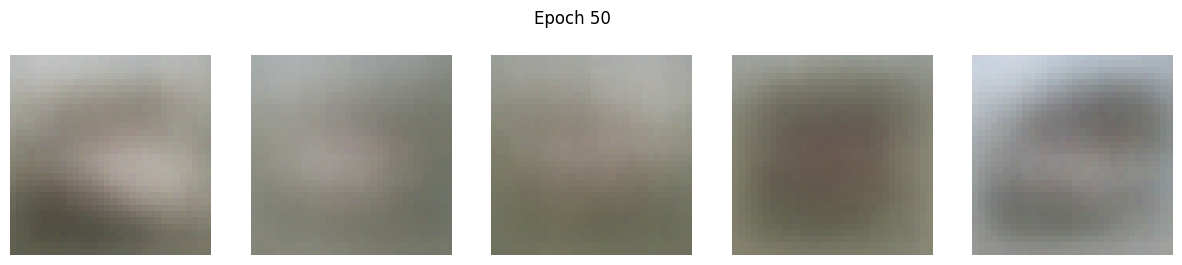

49/49 [==============================] - 5s 112ms/step - loss: 238.2842 - reconstruction_loss: 219.4234 - kl_loss: 18.9322 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 51/500
49/49 [==============================] - 5s 107ms/step - loss: 237.8363 - reconstruction_loss: 218.8567 - kl_loss: 19.0346 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 52/500
49/49 [==============================] - 5s 108ms/step - loss: 237.7315 - reconstruction_loss: 218.4180 - kl_loss: 19.1177 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 53/500
49/49 [==============================] - 5s 108ms/step - loss: 236.9437 - reconstruction_loss: 217.9442 - kl_loss: 19.2725 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 54/500
49/49 [==============================] - 5s 107ms/step - loss: 237.1774 - reconstruc

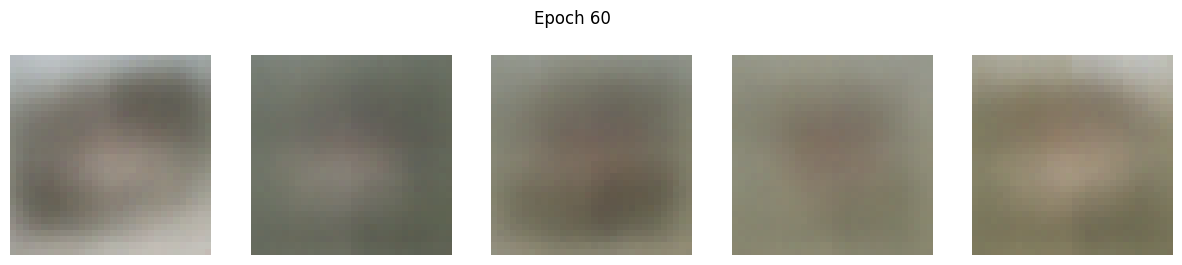

49/49 [==============================] - 6s 113ms/step - loss: 233.9943 - reconstruction_loss: 213.5214 - kl_loss: 20.3068 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 61/500
49/49 [==============================] - 5s 108ms/step - loss: 233.1088 - reconstruction_loss: 212.6528 - kl_loss: 20.5322 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 62/500
49/49 [==============================] - 5s 109ms/step - loss: 232.8674 - reconstruction_loss: 212.2811 - kl_loss: 20.6459 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 63/500
49/49 [==============================] - 5s 108ms/step - loss: 232.7702 - reconstruction_loss: 211.7193 - kl_loss: 20.8037 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 64/500
49/49 [==============================] - 5s 108ms/step - loss: 232.7141 - reconstruc

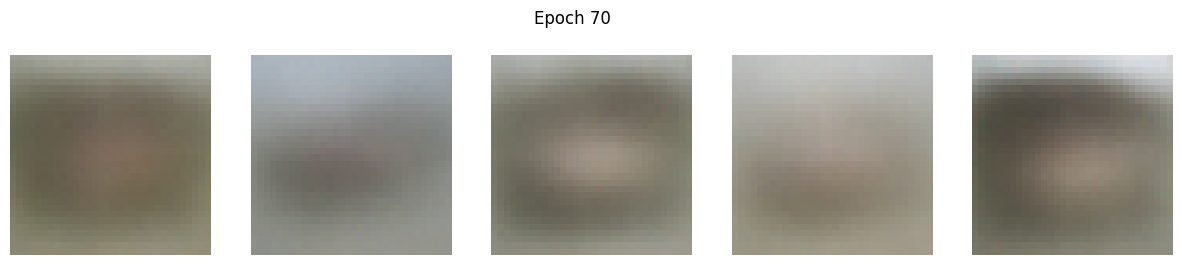

49/49 [==============================] - 5s 112ms/step - loss: 230.9663 - reconstruction_loss: 209.8803 - kl_loss: 21.0413 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 71/500
49/49 [==============================] - 5s 107ms/step - loss: 231.0834 - reconstruction_loss: 209.6333 - kl_loss: 21.1061 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 72/500
49/49 [==============================] - 5s 107ms/step - loss: 230.4497 - reconstruction_loss: 209.5893 - kl_loss: 21.0644 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 73/500
49/49 [==============================] - 5s 108ms/step - loss: 230.4388 - reconstruction_loss: 209.2729 - kl_loss: 21.0683 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 74/500
49/49 [==============================] - 5s 108ms/step - loss: 230.3263 - reconstruc

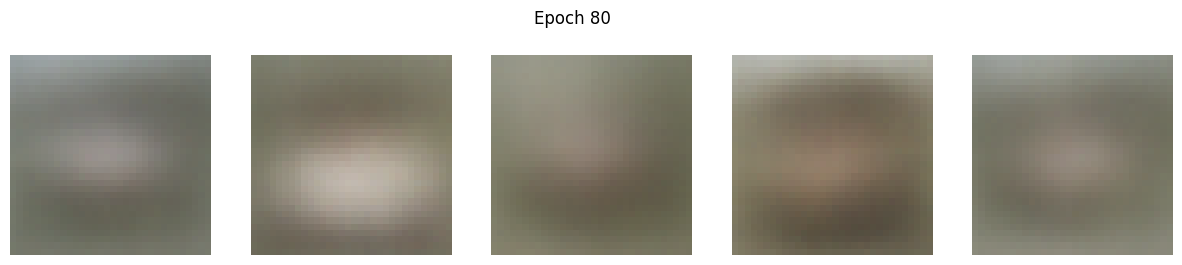

49/49 [==============================] - 6s 112ms/step - loss: 229.7040 - reconstruction_loss: 208.5714 - kl_loss: 21.0663 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 81/500
49/49 [==============================] - 5s 107ms/step - loss: 229.5057 - reconstruction_loss: 208.3971 - kl_loss: 21.0428 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 82/500
49/49 [==============================] - 5s 108ms/step - loss: 229.5850 - reconstruction_loss: 208.3939 - kl_loss: 20.9937 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 83/500
49/49 [==============================] - 5s 107ms/step - loss: 229.5957 - reconstruction_loss: 208.2477 - kl_loss: 21.0360 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 84/500
49/49 [==============================] - 5s 107ms/step - loss: 228.9019 - reconstruc

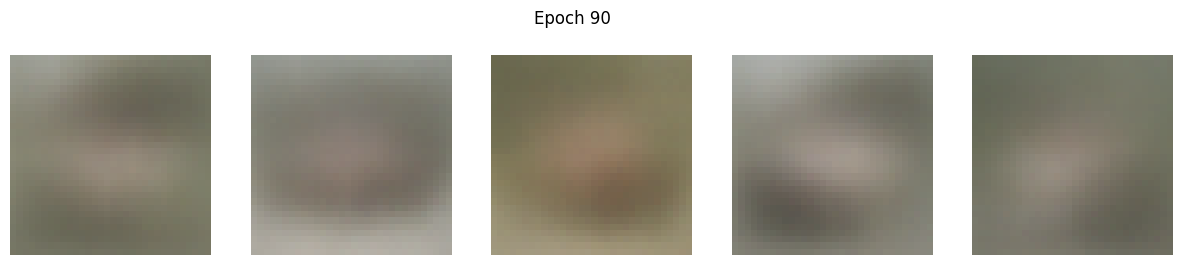

49/49 [==============================] - 5s 111ms/step - loss: 228.5890 - reconstruction_loss: 207.8802 - kl_loss: 20.8517 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 91/500
49/49 [==============================] - 5s 107ms/step - loss: 228.3869 - reconstruction_loss: 207.8101 - kl_loss: 20.8098 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 92/500
49/49 [==============================] - 5s 107ms/step - loss: 228.8665 - reconstruction_loss: 207.9062 - kl_loss: 20.7548 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 93/500
49/49 [==============================] - 5s 108ms/step - loss: 227.8189 - reconstruction_loss: 207.8533 - kl_loss: 20.6905 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 94/500
49/49 [==============================] - 5s 107ms/step - loss: 228.6032 - reconstruc

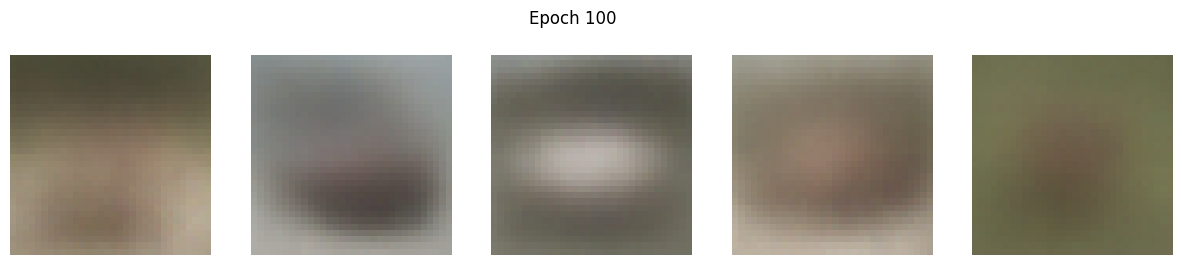

49/49 [==============================] - 5s 112ms/step - loss: 228.2997 - reconstruction_loss: 208.5722 - kl_loss: 19.8027 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 101/500
49/49 [==============================] - 5s 107ms/step - loss: 228.8098 - reconstruction_loss: 208.8426 - kl_loss: 19.6036 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 102/500
49/49 [==============================] - 5s 107ms/step - loss: 228.5228 - reconstruction_loss: 209.1209 - kl_loss: 19.2953 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 103/500
49/49 [==============================] - 5s 108ms/step - loss: 228.2070 - reconstruction_loss: 209.5816 - kl_loss: 18.9271 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 104/500
49/49 [==============================] - 5s 107ms/step - loss: 228.8935 - recons

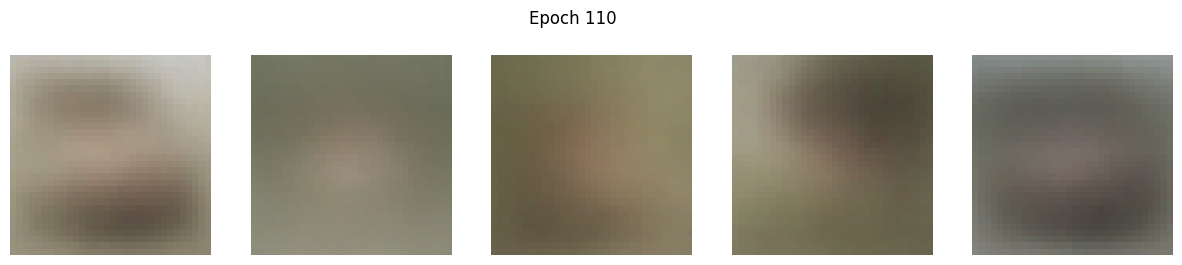

49/49 [==============================] - 6s 114ms/step - loss: 229.7557 - reconstruction_loss: 212.5178 - kl_loss: 16.9820 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 111/500
49/49 [==============================] - 5s 107ms/step - loss: 229.7175 - reconstruction_loss: 212.7986 - kl_loss: 16.7940 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 112/500
49/49 [==============================] - 5s 108ms/step - loss: 229.5736 - reconstruction_loss: 212.9685 - kl_loss: 16.5890 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 113/500
49/49 [==============================] - 5s 108ms/step - loss: 230.2697 - reconstruction_loss: 213.4249 - kl_loss: 16.4344 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 114/500
49/49 [==============================] - 5s 108ms/step - loss: 229.9742 - recons

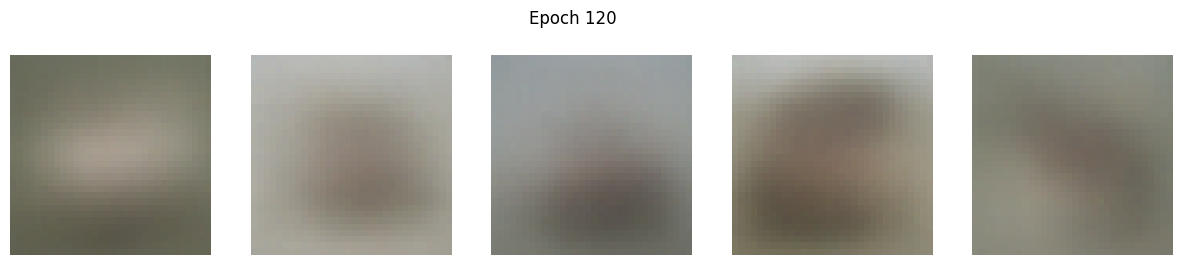

49/49 [==============================] - 5s 112ms/step - loss: 230.5892 - reconstruction_loss: 215.4374 - kl_loss: 15.4163 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 121/500
49/49 [==============================] - 5s 107ms/step - loss: 231.1686 - reconstruction_loss: 215.6007 - kl_loss: 15.3039 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 122/500
49/49 [==============================] - 5s 108ms/step - loss: 230.9519 - reconstruction_loss: 215.7454 - kl_loss: 15.1826 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 123/500
49/49 [==============================] - 5s 107ms/step - loss: 231.1718 - reconstruction_loss: 216.3199 - kl_loss: 14.9674 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 125/500
49/49 [==============================] - 5s 108ms/step - loss: 231.3637 - recons

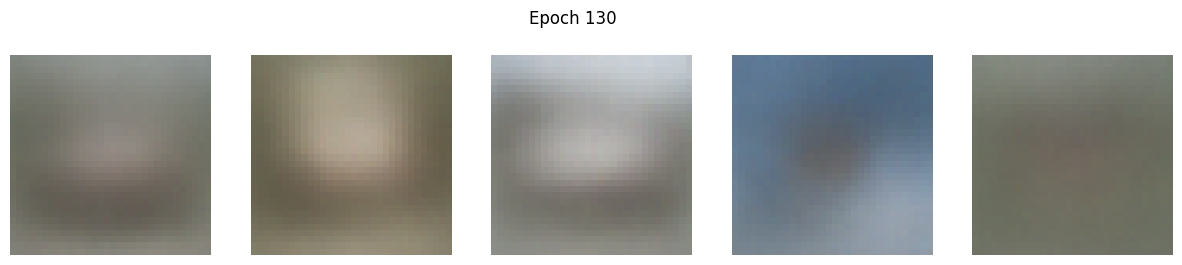

49/49 [==============================] - 6s 120ms/step - loss: 232.4193 - reconstruction_loss: 217.6615 - kl_loss: 14.4280 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 131/500
49/49 [==============================] - 5s 108ms/step - loss: 232.2252 - reconstruction_loss: 217.8056 - kl_loss: 14.3703 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 132/500
49/49 [==============================] - 5s 109ms/step - loss: 232.5243 - reconstruction_loss: 218.2596 - kl_loss: 14.2693 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 133/500
49/49 [==============================] - 5s 108ms/step - loss: 232.4748 - reconstruction_loss: 218.4302 - kl_loss: 14.1983 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 134/500
49/49 [==============================] - 5s 107ms/step - loss: 232.8324 - recons

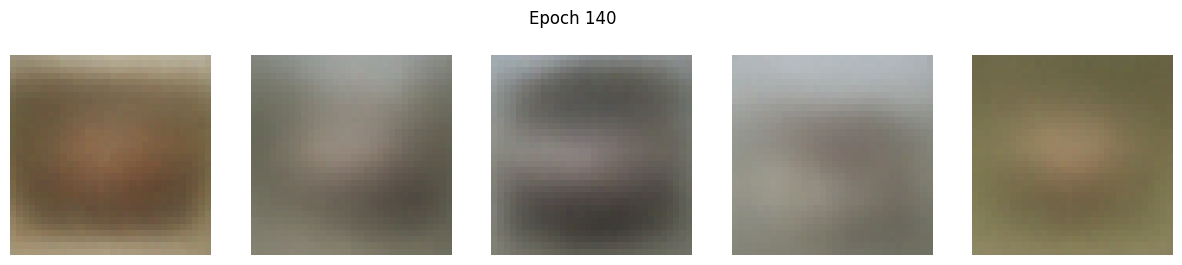

49/49 [==============================] - 6s 113ms/step - loss: 232.9765 - reconstruction_loss: 219.6369 - kl_loss: 13.7624 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 141/500
49/49 [==============================] - 5s 108ms/step - loss: 233.9312 - reconstruction_loss: 219.9973 - kl_loss: 13.7132 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 142/500
49/49 [==============================] - 5s 109ms/step - loss: 233.9422 - reconstruction_loss: 220.1743 - kl_loss: 13.6785 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 143/500
49/49 [==============================] - 5s 109ms/step - loss: 233.5641 - reconstruction_loss: 220.2277 - kl_loss: 13.6376 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 144/500
49/49 [==============================] - 5s 108ms/step - loss: 234.0653 - recons

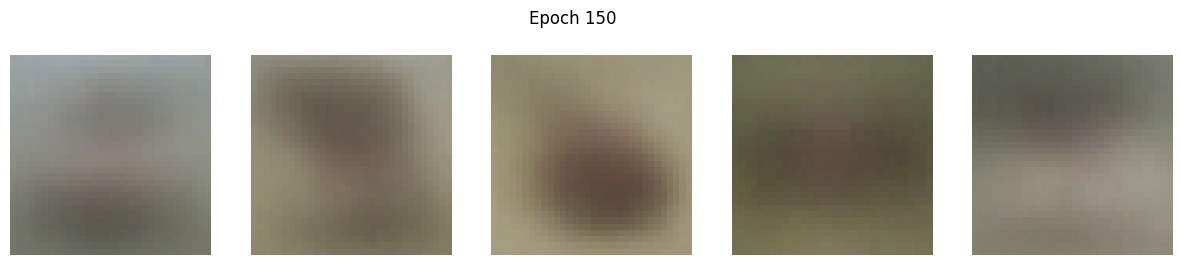

49/49 [==============================] - 5s 111ms/step - loss: 235.3445 - reconstruction_loss: 221.4475 - kl_loss: 13.3376 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 151/500
49/49 [==============================] - 5s 108ms/step - loss: 235.0376 - reconstruction_loss: 221.6051 - kl_loss: 13.2988 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 152/500
49/49 [==============================] - 5s 108ms/step - loss: 235.3513 - reconstruction_loss: 221.7122 - kl_loss: 13.2698 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 153/500
49/49 [==============================] - 5s 109ms/step - loss: 235.4647 - reconstruction_loss: 221.9840 - kl_loss: 13.2395 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 154/500
49/49 [==============================] - 5s 108ms/step - loss: 235.4943 - recons

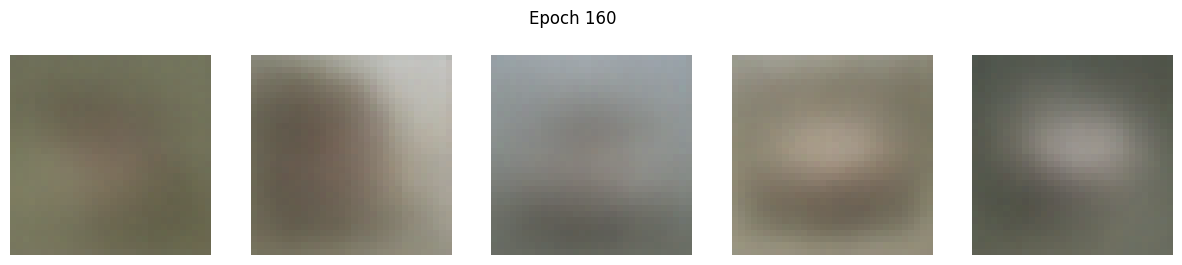

49/49 [==============================] - 5s 112ms/step - loss: 235.7097 - reconstruction_loss: 222.8226 - kl_loss: 13.1081 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 161/500
49/49 [==============================] - 5s 109ms/step - loss: 235.6469 - reconstruction_loss: 222.8818 - kl_loss: 13.0863 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 162/500
49/49 [==============================] - 5s 109ms/step - loss: 235.9115 - reconstruction_loss: 223.1315 - kl_loss: 13.0821 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 163/500
49/49 [==============================] - 5s 108ms/step - loss: 235.8725 - reconstruction_loss: 223.2145 - kl_loss: 13.0590 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 164/500
49/49 [==============================] - 5s 108ms/step - loss: 236.7292 - recons

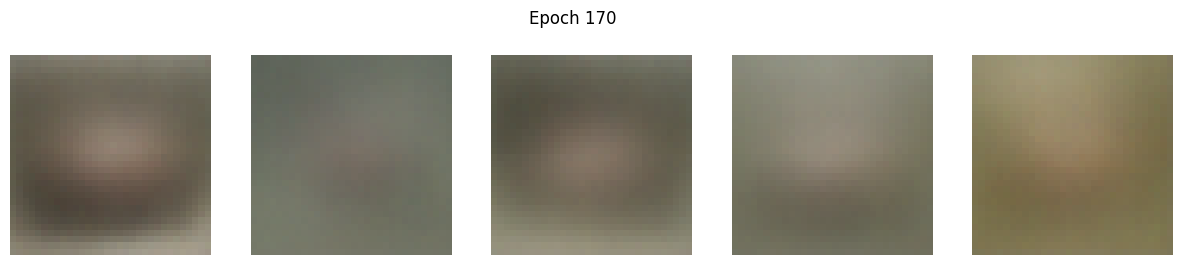

49/49 [==============================] - 5s 112ms/step - loss: 236.8581 - reconstruction_loss: 224.1213 - kl_loss: 12.9827 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 171/500
49/49 [==============================] - 5s 109ms/step - loss: 236.6328 - reconstruction_loss: 224.2352 - kl_loss: 12.9548 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 172/500
49/49 [==============================] - 5s 109ms/step - loss: 236.9870 - reconstruction_loss: 224.1225 - kl_loss: 12.9566 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 173/500
49/49 [==============================] - 5s 109ms/step - loss: 237.3250 - reconstruction_loss: 224.2971 - kl_loss: 12.9432 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 174/500
49/49 [==============================] - 5s 110ms/step - loss: 237.4132 - recons

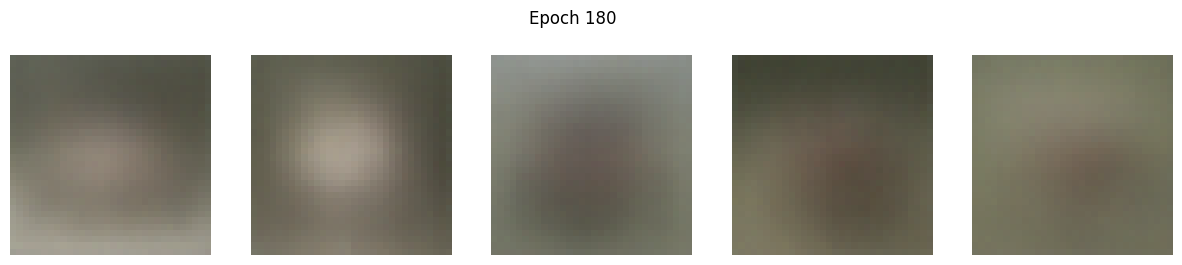

49/49 [==============================] - 6s 114ms/step - loss: 238.2375 - reconstruction_loss: 224.8656 - kl_loss: 12.9064 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 181/500
49/49 [==============================] - 5s 108ms/step - loss: 238.2978 - reconstruction_loss: 225.1890 - kl_loss: 12.9070 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 182/500
49/49 [==============================] - 5s 108ms/step - loss: 237.9757 - reconstruction_loss: 225.0332 - kl_loss: 12.8940 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 183/500
49/49 [==============================] - 5s 108ms/step - loss: 237.7955 - reconstruction_loss: 225.1203 - kl_loss: 12.8922 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 184/500
49/49 [==============================] - 5s 107ms/step - loss: 238.3734 - recons

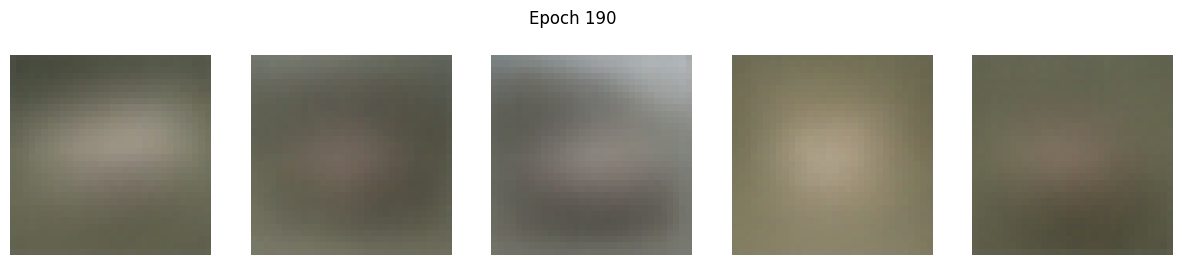

49/49 [==============================] - 6s 113ms/step - loss: 238.2843 - reconstruction_loss: 225.6077 - kl_loss: 12.8687 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 191/500
49/49 [==============================] - 5s 108ms/step - loss: 239.0217 - reconstruction_loss: 225.9719 - kl_loss: 12.8553 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 192/500
49/49 [==============================] - 5s 108ms/step - loss: 239.1184 - reconstruction_loss: 225.9197 - kl_loss: 12.8535 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 193/500
49/49 [==============================] - 5s 108ms/step - loss: 238.9334 - reconstruction_loss: 225.9812 - kl_loss: 12.8600 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 194/500
49/49 [==============================] - 5s 107ms/step - loss: 239.3557 - recons

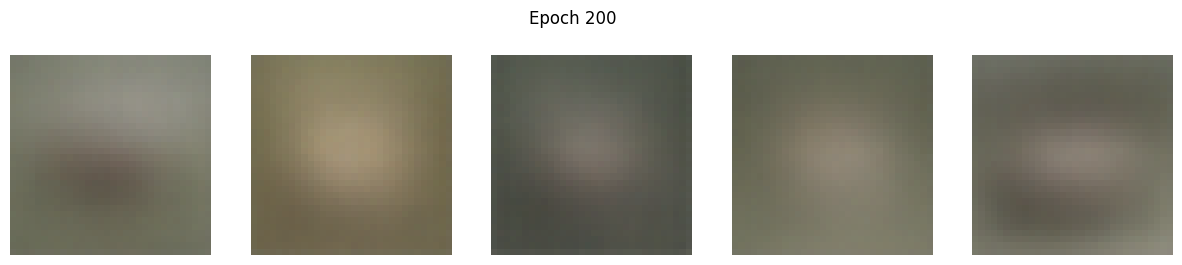

49/49 [==============================] - 6s 113ms/step - loss: 238.9698 - reconstruction_loss: 226.1382 - kl_loss: 12.8422 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 201/500
49/49 [==============================] - 5s 108ms/step - loss: 238.9738 - reconstruction_loss: 226.4112 - kl_loss: 12.8186 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 202/500
49/49 [==============================] - 5s 108ms/step - loss: 239.3497 - reconstruction_loss: 226.4242 - kl_loss: 12.8072 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 203/500
49/49 [==============================] - 5s 108ms/step - loss: 238.6719 - reconstruction_loss: 226.4430 - kl_loss: 12.7948 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 204/500
49/49 [==============================] - 5s 109ms/step - loss: 239.3523 - recons

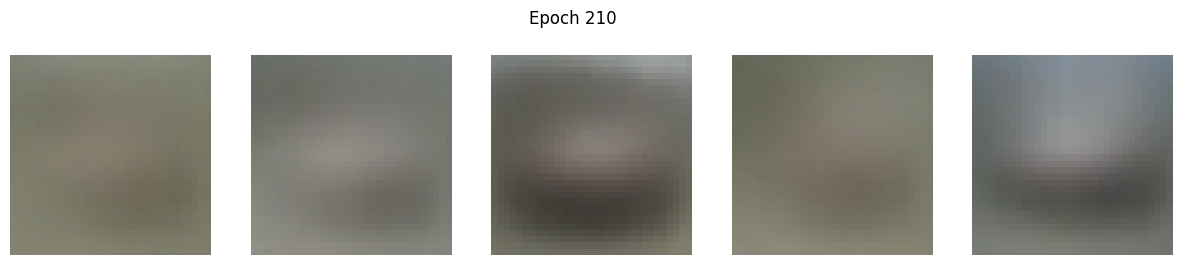

49/49 [==============================] - 5s 112ms/step - loss: 239.4288 - reconstruction_loss: 226.6906 - kl_loss: 12.8002 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 211/500
49/49 [==============================] - 5s 108ms/step - loss: 240.1714 - reconstruction_loss: 226.8789 - kl_loss: 12.7734 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 212/500
49/49 [==============================] - 5s 108ms/step - loss: 239.7836 - reconstruction_loss: 226.9670 - kl_loss: 12.7677 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 213/500
49/49 [==============================] - 5s 108ms/step - loss: 239.7471 - reconstruction_loss: 226.8534 - kl_loss: 12.7690 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 214/500
49/49 [==============================] - 5s 108ms/step - loss: 239.5401 - recons

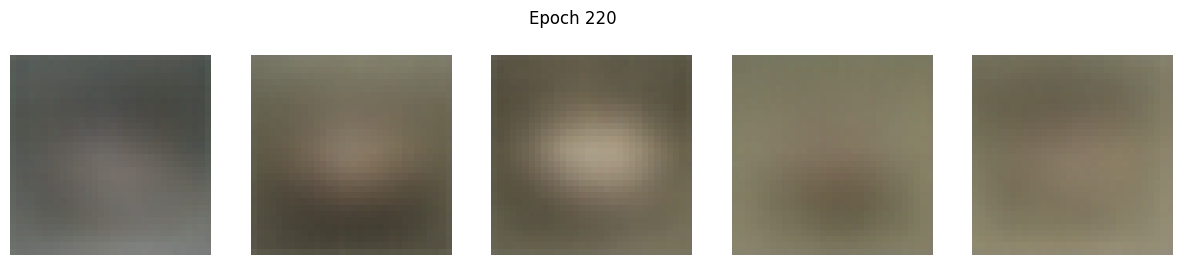

49/49 [==============================] - 6s 113ms/step - loss: 240.2485 - reconstruction_loss: 227.1686 - kl_loss: 12.7233 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 221/500
49/49 [==============================] - 5s 109ms/step - loss: 240.3558 - reconstruction_loss: 227.3444 - kl_loss: 12.7174 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 222/500
49/49 [==============================] - 5s 108ms/step - loss: 240.2184 - reconstruction_loss: 227.4521 - kl_loss: 12.7205 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 223/500
49/49 [==============================] - 5s 108ms/step - loss: 239.3723 - reconstruction_loss: 227.2813 - kl_loss: 12.7055 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 224/500
49/49 [==============================] - 5s 108ms/step - loss: 240.0657 - recons

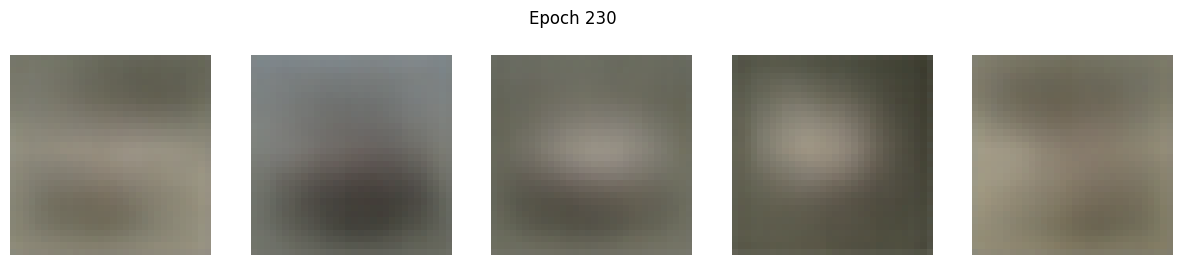

49/49 [==============================] - 5s 112ms/step - loss: 240.1409 - reconstruction_loss: 227.7460 - kl_loss: 12.6119 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 231/500
49/49 [==============================] - 5s 107ms/step - loss: 240.7491 - reconstruction_loss: 227.8333 - kl_loss: 12.6270 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 232/500
49/49 [==============================] - 5s 108ms/step - loss: 241.0157 - reconstruction_loss: 227.9492 - kl_loss: 12.6018 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 233/500
49/49 [==============================] - 5s 108ms/step - loss: 240.4172 - reconstruction_loss: 227.9765 - kl_loss: 12.5990 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 234/500
49/49 [==============================] - 5s 108ms/step - loss: 241.1449 - recons

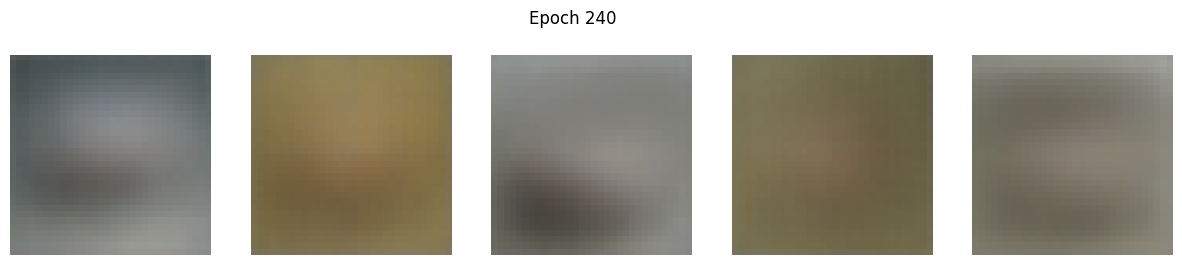

49/49 [==============================] - 6s 113ms/step - loss: 241.3284 - reconstruction_loss: 228.5454 - kl_loss: 12.5399 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 241/500
49/49 [==============================] - 5s 108ms/step - loss: 241.5305 - reconstruction_loss: 228.3610 - kl_loss: 12.5212 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 242/500
49/49 [==============================] - 5s 108ms/step - loss: 240.8782 - reconstruction_loss: 228.4857 - kl_loss: 12.4900 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 243/500
49/49 [==============================] - 5s 108ms/step - loss: 240.7355 - reconstruction_loss: 228.6266 - kl_loss: 12.4670 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 244/500
49/49 [==============================] - 5s 108ms/step - loss: 240.8482 - recons

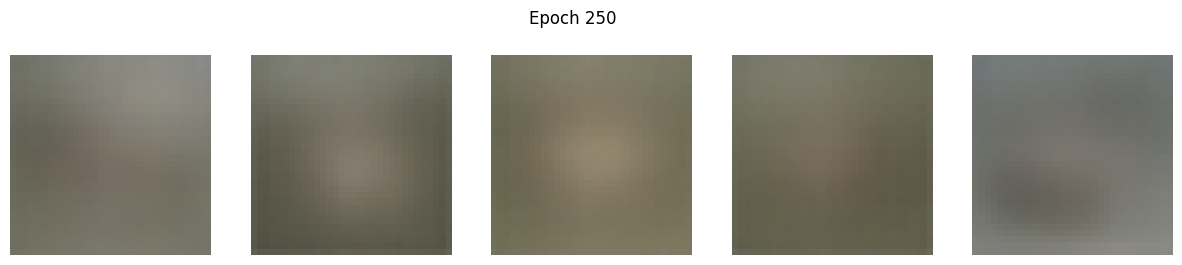

49/49 [==============================] - 5s 112ms/step - loss: 241.7285 - reconstruction_loss: 229.0464 - kl_loss: 12.3556 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 251/500
49/49 [==============================] - 5s 108ms/step - loss: 241.6108 - reconstruction_loss: 229.1324 - kl_loss: 12.3281 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 252/500
49/49 [==============================] - 5s 107ms/step - loss: 241.6971 - reconstruction_loss: 229.1533 - kl_loss: 12.3237 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 253/500
49/49 [==============================] - 5s 108ms/step - loss: 241.9206 - reconstruction_loss: 229.2217 - kl_loss: 12.3000 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 254/500
49/49 [==============================] - 5s 107ms/step - loss: 241.9594 - recons

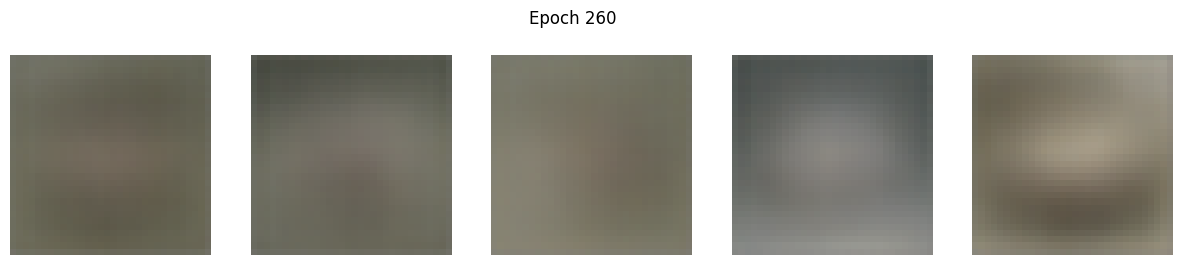

49/49 [==============================] - 6s 113ms/step - loss: 242.2594 - reconstruction_loss: 229.9516 - kl_loss: 12.1703 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 261/500
49/49 [==============================] - 5s 108ms/step - loss: 242.3425 - reconstruction_loss: 230.2086 - kl_loss: 12.1494 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 262/500
49/49 [==============================] - 5s 109ms/step - loss: 242.6840 - reconstruction_loss: 230.0594 - kl_loss: 12.1476 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 263/500
49/49 [==============================] - 5s 108ms/step - loss: 242.3911 - reconstruction_loss: 230.3466 - kl_loss: 12.1035 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 264/500
49/49 [==============================] - 5s 109ms/step - loss: 242.6399 - recons

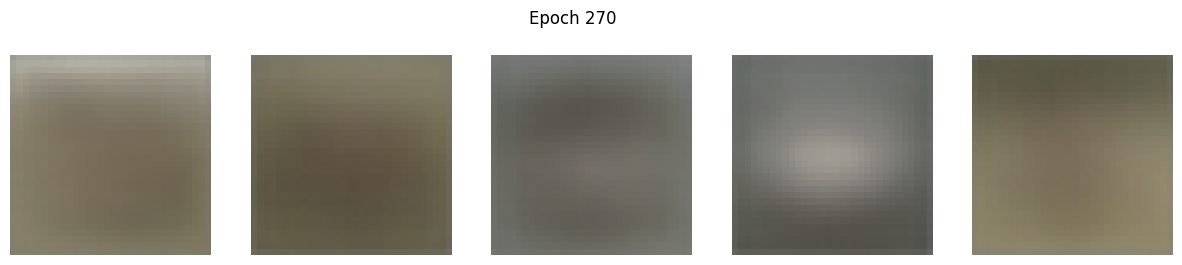

49/49 [==============================] - 5s 112ms/step - loss: 243.0611 - reconstruction_loss: 230.9199 - kl_loss: 11.9640 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 271/500
49/49 [==============================] - 5s 107ms/step - loss: 243.0873 - reconstruction_loss: 231.1296 - kl_loss: 11.9336 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 272/500
49/49 [==============================] - 5s 108ms/step - loss: 242.9569 - reconstruction_loss: 231.2408 - kl_loss: 11.9064 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 273/500
49/49 [==============================] - 5s 108ms/step - loss: 243.2532 - reconstruction_loss: 231.1924 - kl_loss: 11.8930 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 274/500
49/49 [==============================] - 5s 109ms/step - loss: 243.0809 - recons

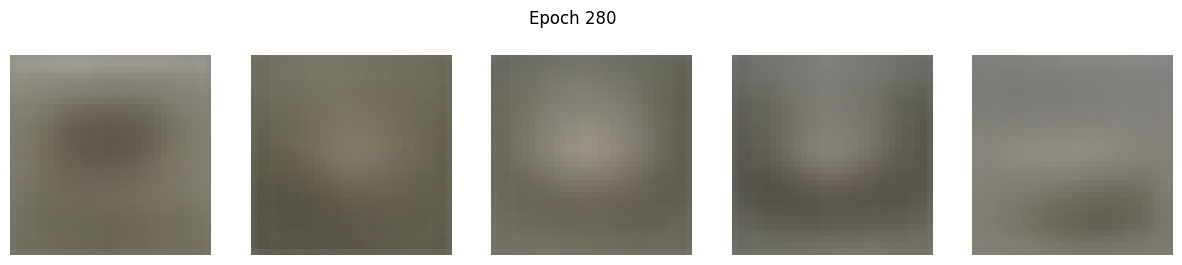

49/49 [==============================] - 6s 113ms/step - loss: 244.1987 - reconstruction_loss: 232.1915 - kl_loss: 11.7117 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 281/500
49/49 [==============================] - 5s 108ms/step - loss: 243.6902 - reconstruction_loss: 232.2282 - kl_loss: 11.6825 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 282/500
49/49 [==============================] - 5s 108ms/step - loss: 243.8317 - reconstruction_loss: 232.5160 - kl_loss: 11.6664 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 283/500
49/49 [==============================] - 5s 108ms/step - loss: 243.2346 - reconstruction_loss: 232.3096 - kl_loss: 11.6398 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 284/500
49/49 [==============================] - 5s 107ms/step - loss: 243.6979 - recons

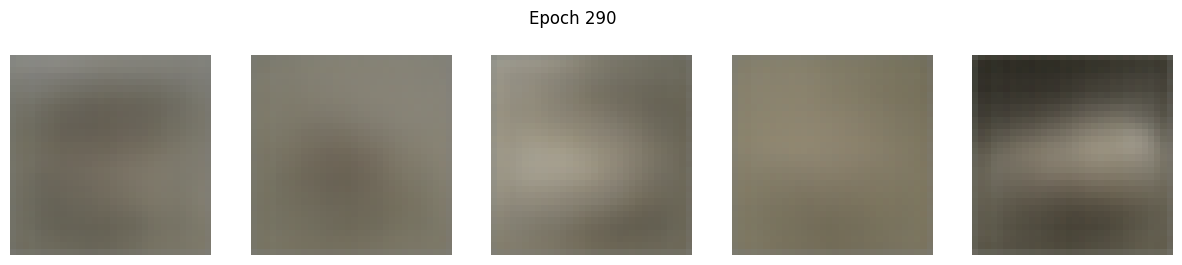

49/49 [==============================] - 5s 111ms/step - loss: 244.8114 - reconstruction_loss: 233.4561 - kl_loss: 11.4371 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 291/500
49/49 [==============================] - 5s 108ms/step - loss: 244.5650 - reconstruction_loss: 233.6239 - kl_loss: 11.3888 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 292/500
49/49 [==============================] - 5s 107ms/step - loss: 245.1588 - reconstruction_loss: 233.7855 - kl_loss: 11.3899 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 293/500
49/49 [==============================] - 5s 108ms/step - loss: 245.0675 - reconstruction_loss: 233.9943 - kl_loss: 11.3690 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 294/500
49/49 [==============================] - 5s 107ms/step - loss: 245.5811 - recons

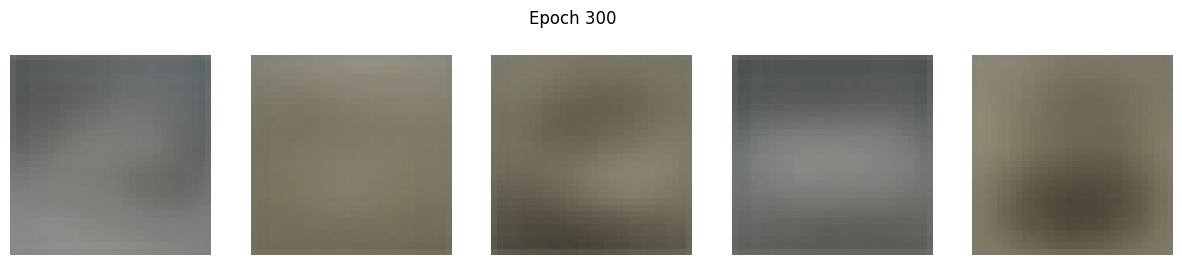

49/49 [==============================] - 6s 120ms/step - loss: 246.2954 - reconstruction_loss: 235.0262 - kl_loss: 11.1528 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 301/500
49/49 [==============================] - 5s 107ms/step - loss: 246.2223 - reconstruction_loss: 235.0483 - kl_loss: 11.1345 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 302/500
49/49 [==============================] - 5s 107ms/step - loss: 246.6259 - reconstruction_loss: 235.1539 - kl_loss: 11.0933 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 303/500
49/49 [==============================] - 5s 107ms/step - loss: 246.3702 - reconstruction_loss: 235.3999 - kl_loss: 11.0513 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 304/500
49/49 [==============================] - 5s 109ms/step - loss: 246.3447 - recons

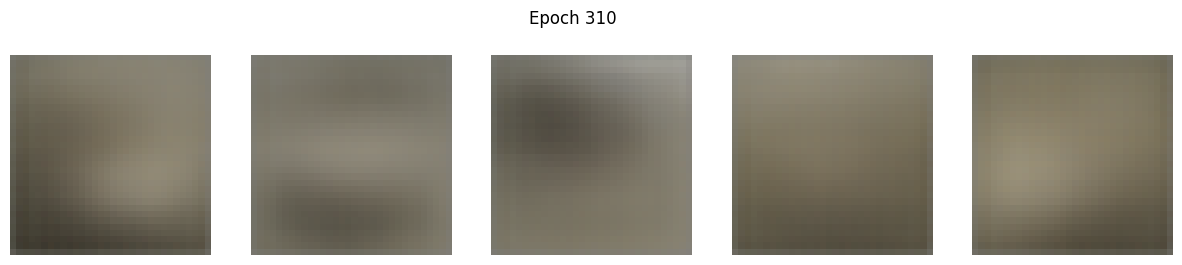

49/49 [==============================] - 6s 114ms/step - loss: 247.1753 - reconstruction_loss: 236.5309 - kl_loss: 10.8699 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 311/500
49/49 [==============================] - 5s 108ms/step - loss: 247.2018 - reconstruction_loss: 236.6767 - kl_loss: 10.8359 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 312/500
49/49 [==============================] - 5s 108ms/step - loss: 247.5956 - reconstruction_loss: 237.0936 - kl_loss: 10.8045 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 313/500
49/49 [==============================] - 5s 108ms/step - loss: 247.7283 - reconstruction_loss: 237.0100 - kl_loss: 10.7768 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 314/500
49/49 [==============================] - 5s 108ms/step - loss: 247.7295 - recons

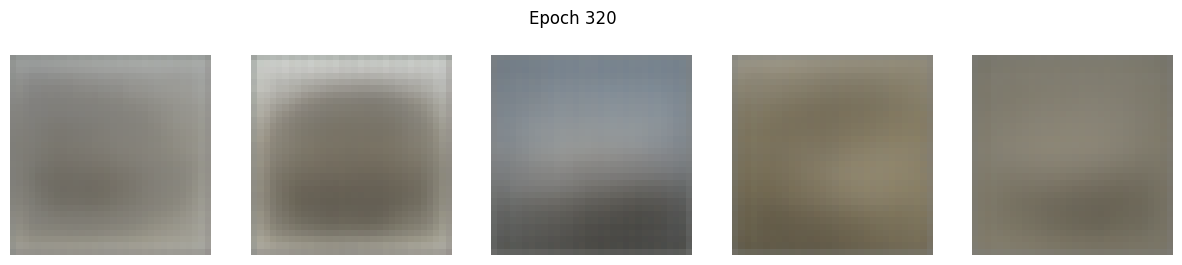

49/49 [==============================] - 6s 113ms/step - loss: 248.4314 - reconstruction_loss: 238.3107 - kl_loss: 10.5348 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 321/500
49/49 [==============================] - 5s 109ms/step - loss: 249.0207 - reconstruction_loss: 238.5108 - kl_loss: 10.5195 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 322/500
49/49 [==============================] - 5s 109ms/step - loss: 248.7372 - reconstruction_loss: 238.5513 - kl_loss: 10.4874 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 323/500
49/49 [==============================] - 5s 109ms/step - loss: 249.4157 - reconstruction_loss: 238.8617 - kl_loss: 10.4525 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 324/500
49/49 [==============================] - 5s 108ms/step - loss: 249.3803 - recons

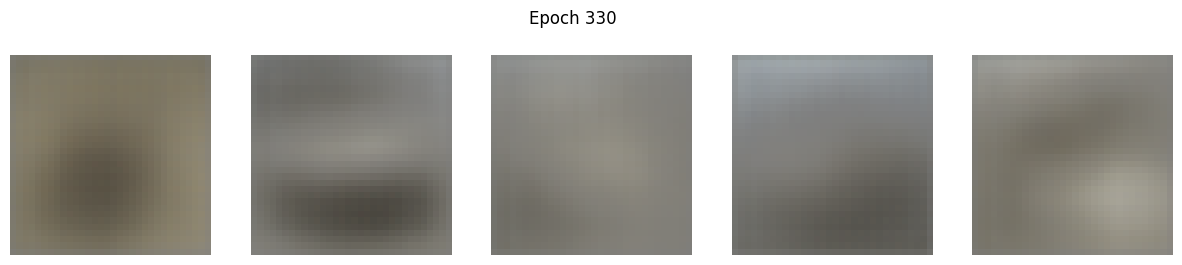

49/49 [==============================] - 5s 112ms/step - loss: 250.1669 - reconstruction_loss: 240.1008 - kl_loss: 10.2375 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 331/500
49/49 [==============================] - 5s 108ms/step - loss: 250.7039 - reconstruction_loss: 240.2359 - kl_loss: 10.2044 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 332/500
49/49 [==============================] - 5s 108ms/step - loss: 250.3961 - reconstruction_loss: 240.3518 - kl_loss: 10.1660 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 333/500
49/49 [==============================] - 5s 108ms/step - loss: 251.0980 - reconstruction_loss: 240.5951 - kl_loss: 10.1269 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 334/500
49/49 [==============================] - 5s 107ms/step - loss: 250.8516 - recons

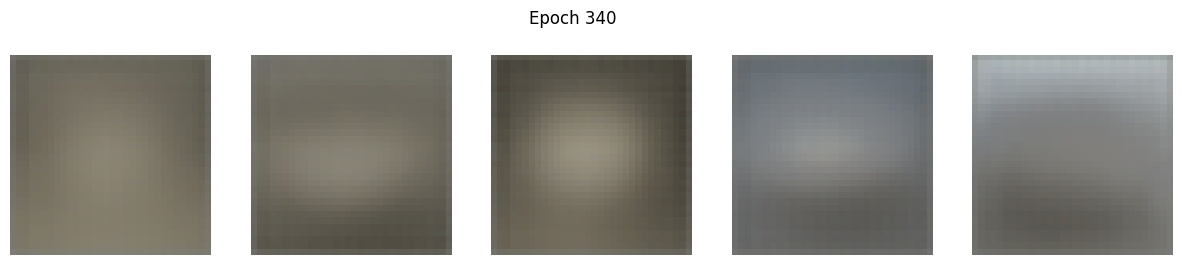

49/49 [==============================] - 6s 113ms/step - loss: 252.1807 - reconstruction_loss: 241.9877 - kl_loss: 9.9065 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 341/500
49/49 [==============================] - 5s 107ms/step - loss: 251.8873 - reconstruction_loss: 242.2697 - kl_loss: 9.8954 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 342/500
49/49 [==============================] - 5s 108ms/step - loss: 252.6739 - reconstruction_loss: 242.3800 - kl_loss: 9.8636 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 343/500
49/49 [==============================] - 5s 108ms/step - loss: 252.4632 - reconstruction_loss: 242.5383 - kl_loss: 9.8246 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 344/500
49/49 [==============================] - 5s 108ms/step - loss: 252.6015 - reconstruc

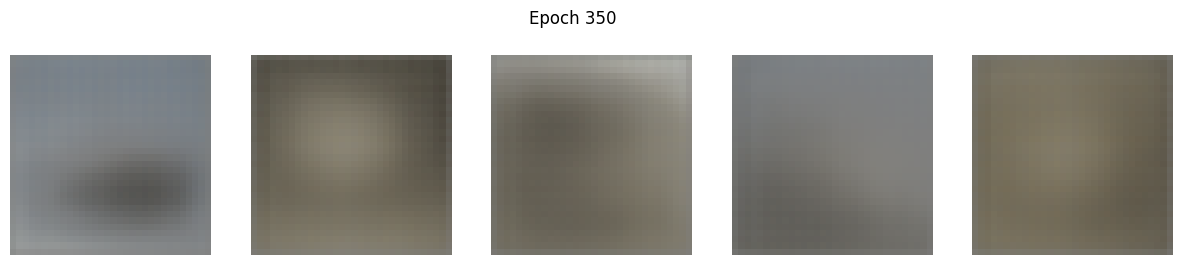

49/49 [==============================] - 5s 112ms/step - loss: 253.0878 - reconstruction_loss: 244.0179 - kl_loss: 9.6388 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 351/500
49/49 [==============================] - 5s 107ms/step - loss: 253.3826 - reconstruction_loss: 244.1603 - kl_loss: 9.6124 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 352/500
49/49 [==============================] - 5s 107ms/step - loss: 253.9130 - reconstruction_loss: 244.5610 - kl_loss: 9.5757 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 353/500
49/49 [==============================] - 5s 107ms/step - loss: 254.3557 - reconstruction_loss: 244.6463 - kl_loss: 9.5554 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 354/500
49/49 [==============================] - 5s 107ms/step - loss: 254.2498 - reconstruc

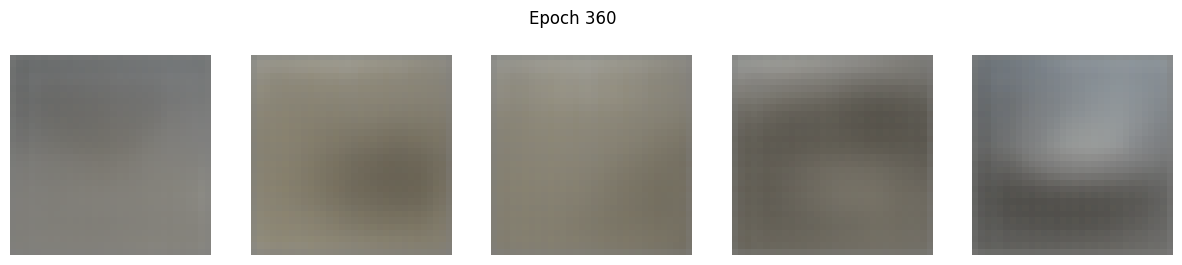

49/49 [==============================] - 5s 112ms/step - loss: 255.2252 - reconstruction_loss: 246.0211 - kl_loss: 9.3556 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 361/500
49/49 [==============================] - 5s 108ms/step - loss: 255.4078 - reconstruction_loss: 246.3053 - kl_loss: 9.3349 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 362/500
49/49 [==============================] - 5s 109ms/step - loss: 255.4450 - reconstruction_loss: 246.5219 - kl_loss: 9.3000 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 363/500
49/49 [==============================] - 5s 108ms/step - loss: 255.5896 - reconstruction_loss: 246.7062 - kl_loss: 9.2814 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 364/500
49/49 [==============================] - 5s 108ms/step - loss: 256.0868 - reconstruc

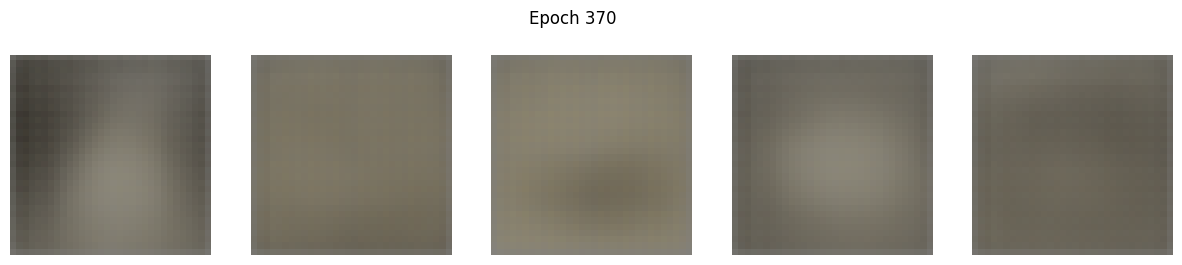

49/49 [==============================] - 6s 113ms/step - loss: 256.7738 - reconstruction_loss: 247.9874 - kl_loss: 9.1039 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 371/500
49/49 [==============================] - 5s 109ms/step - loss: 257.3931 - reconstruction_loss: 248.4096 - kl_loss: 9.0864 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 372/500
49/49 [==============================] - 5s 109ms/step - loss: 258.2765 - reconstruction_loss: 248.4767 - kl_loss: 9.0664 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 373/500
49/49 [==============================] - 5s 108ms/step - loss: 257.8338 - reconstruction_loss: 248.7607 - kl_loss: 9.0325 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 374/500
49/49 [==============================] - 5s 108ms/step - loss: 257.8161 - reconstruc

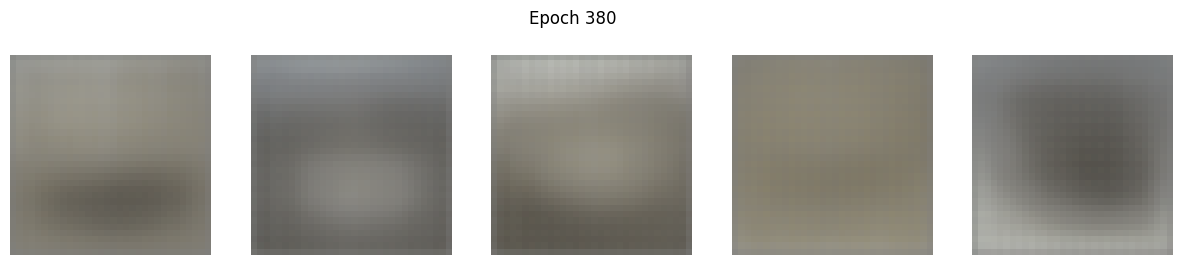

49/49 [==============================] - 5s 111ms/step - loss: 258.9355 - reconstruction_loss: 250.1898 - kl_loss: 8.8526 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 381/500
49/49 [==============================] - 5s 108ms/step - loss: 258.9274 - reconstruction_loss: 250.3137 - kl_loss: 8.8330 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 382/500
49/49 [==============================] - 5s 108ms/step - loss: 258.7903 - reconstruction_loss: 250.5544 - kl_loss: 8.8171 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 383/500
49/49 [==============================] - 5s 110ms/step - loss: 259.4581 - reconstruction_loss: 250.7334 - kl_loss: 8.7813 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 384/500
49/49 [==============================] - 5s 109ms/step - loss: 260.1171 - reconstruc

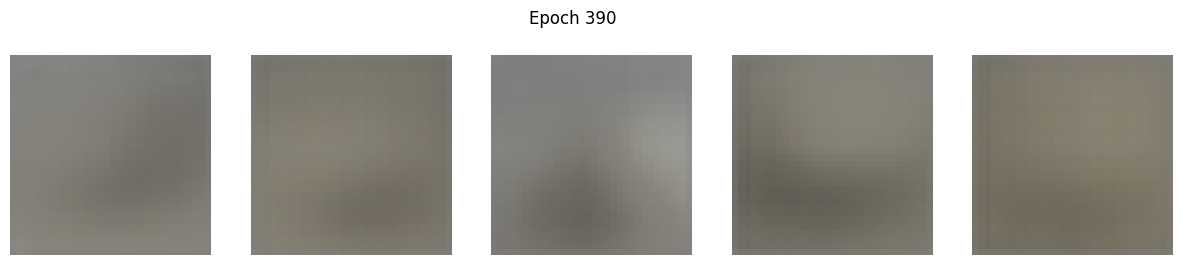

49/49 [==============================] - 6s 114ms/step - loss: 261.2949 - reconstruction_loss: 252.2940 - kl_loss: 8.6117 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 391/500
49/49 [==============================] - 5s 108ms/step - loss: 260.7879 - reconstruction_loss: 252.3813 - kl_loss: 8.5865 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 392/500
49/49 [==============================] - 5s 108ms/step - loss: 260.9536 - reconstruction_loss: 252.6889 - kl_loss: 8.5779 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 393/500
49/49 [==============================] - 5s 109ms/step - loss: 261.5696 - reconstruction_loss: 252.7968 - kl_loss: 8.5561 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 394/500
49/49 [==============================] - 5s 108ms/step - loss: 261.1225 - reconstruc

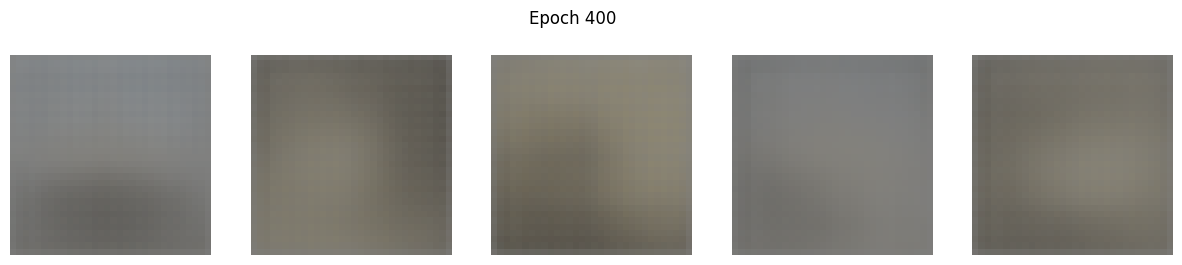

49/49 [==============================] - 5s 112ms/step - loss: 262.8507 - reconstruction_loss: 254.3391 - kl_loss: 8.3993 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 401/500
49/49 [==============================] - 5s 108ms/step - loss: 263.3792 - reconstruction_loss: 254.4729 - kl_loss: 8.3893 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 402/500
49/49 [==============================] - 5s 109ms/step - loss: 262.8642 - reconstruction_loss: 254.5426 - kl_loss: 8.3636 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 403/500
49/49 [==============================] - 5s 108ms/step - loss: 263.0488 - reconstruction_loss: 254.9901 - kl_loss: 8.3456 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 404/500
49/49 [==============================] - 5s 108ms/step - loss: 263.3171 - reconstruc

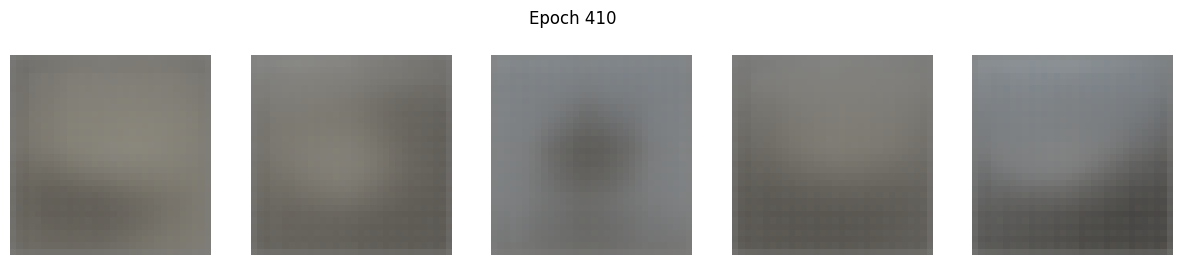

49/49 [==============================] - 5s 112ms/step - loss: 264.5974 - reconstruction_loss: 256.3342 - kl_loss: 8.2203 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 411/500
49/49 [==============================] - 5s 109ms/step - loss: 264.7477 - reconstruction_loss: 256.5344 - kl_loss: 8.1954 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 412/500
49/49 [==============================] - 5s 109ms/step - loss: 264.7926 - reconstruction_loss: 256.6514 - kl_loss: 8.1740 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 413/500
49/49 [==============================] - 5s 109ms/step - loss: 265.1473 - reconstruction_loss: 256.9132 - kl_loss: 8.1585 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 414/500
49/49 [==============================] - 5s 109ms/step - loss: 265.3671 - reconstruc

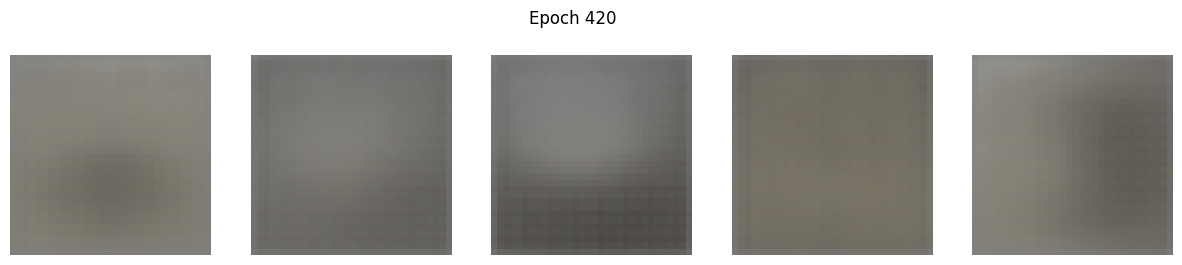

49/49 [==============================] - 5s 112ms/step - loss: 266.3664 - reconstruction_loss: 258.4093 - kl_loss: 8.0355 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 421/500
49/49 [==============================] - 5s 108ms/step - loss: 266.4510 - reconstruction_loss: 258.5927 - kl_loss: 8.0007 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 422/500
49/49 [==============================] - 5s 108ms/step - loss: 266.6434 - reconstruction_loss: 258.8074 - kl_loss: 7.9891 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 423/500
49/49 [==============================] - 5s 109ms/step - loss: 266.2331 - reconstruction_loss: 258.9348 - kl_loss: 7.9780 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 424/500
49/49 [==============================] - 5s 109ms/step - loss: 266.8795 - reconstruc

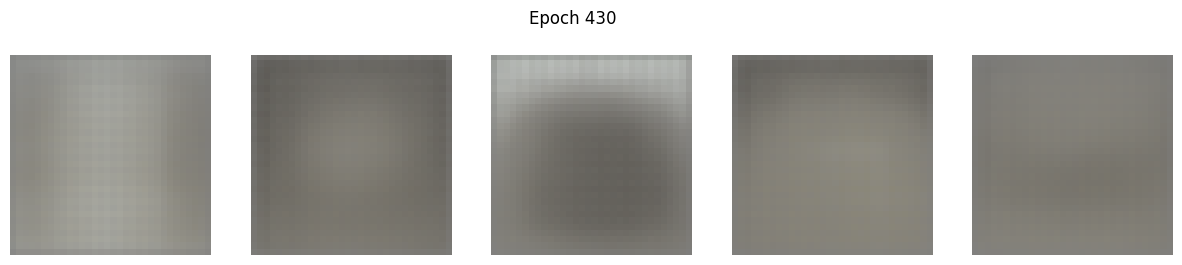

49/49 [==============================] - 6s 114ms/step - loss: 268.5413 - reconstruction_loss: 260.3324 - kl_loss: 7.8492 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 431/500
49/49 [==============================] - 5s 108ms/step - loss: 269.0122 - reconstruction_loss: 260.5149 - kl_loss: 7.8495 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 432/500
49/49 [==============================] - 5s 108ms/step - loss: 268.2165 - reconstruction_loss: 260.7052 - kl_loss: 7.8334 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 433/500
49/49 [==============================] - 5s 108ms/step - loss: 268.2085 - reconstruction_loss: 260.9446 - kl_loss: 7.8096 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 434/500
49/49 [==============================] - 5s 109ms/step - loss: 269.0057 - reconstruc

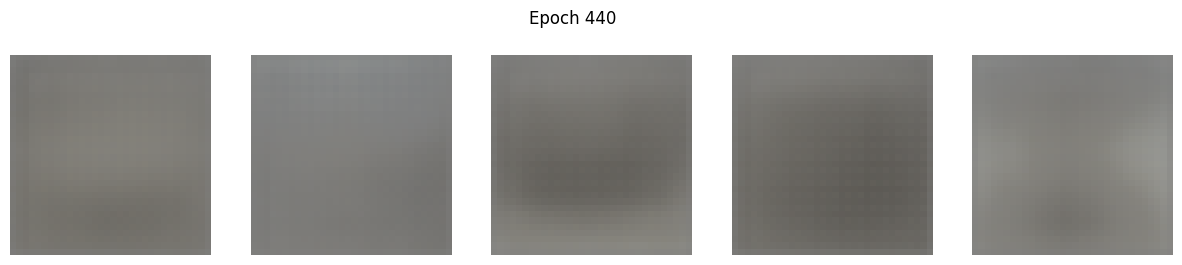

49/49 [==============================] - 5s 112ms/step - loss: 269.4303 - reconstruction_loss: 262.1768 - kl_loss: 7.7064 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 441/500
49/49 [==============================] - 5s 107ms/step - loss: 270.3845 - reconstruction_loss: 262.5872 - kl_loss: 7.6776 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 442/500
49/49 [==============================] - 5s 108ms/step - loss: 270.3441 - reconstruction_loss: 262.7372 - kl_loss: 7.6734 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 443/500
49/49 [==============================] - 5s 108ms/step - loss: 271.0862 - reconstruction_loss: 262.8442 - kl_loss: 7.6605 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 444/500
49/49 [==============================] - 5s 108ms/step - loss: 270.6005 - reconstruc

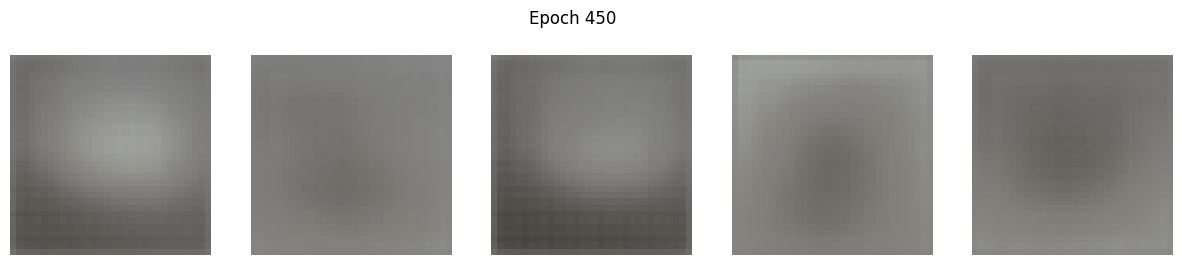

49/49 [==============================] - 5s 112ms/step - loss: 272.1234 - reconstruction_loss: 264.1606 - kl_loss: 7.5492 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 451/500
49/49 [==============================] - 5s 108ms/step - loss: 272.3782 - reconstruction_loss: 264.4927 - kl_loss: 7.5409 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 452/500
49/49 [==============================] - 5s 108ms/step - loss: 271.9225 - reconstruction_loss: 264.5207 - kl_loss: 7.5300 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 453/500
49/49 [==============================] - 5s 107ms/step - loss: 272.1902 - reconstruction_loss: 264.7580 - kl_loss: 7.5266 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 454/500
49/49 [==============================] - 5s 107ms/step - loss: 272.6410 - reconstruc

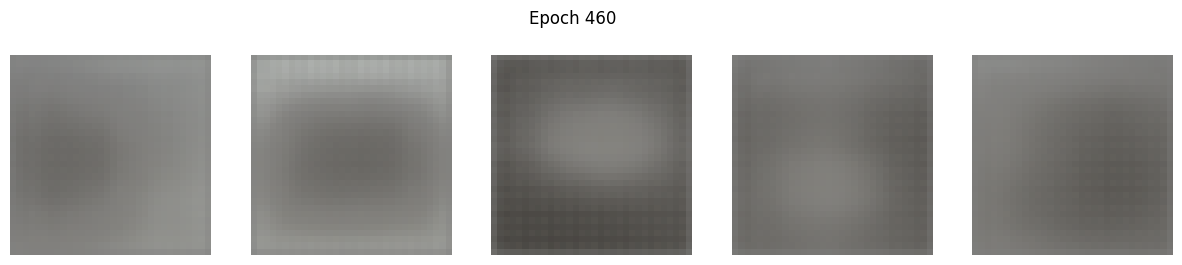

49/49 [==============================] - 5s 112ms/step - loss: 273.6864 - reconstruction_loss: 266.0087 - kl_loss: 7.4165 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 461/500
49/49 [==============================] - 5s 107ms/step - loss: 273.1732 - reconstruction_loss: 266.1894 - kl_loss: 7.3825 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 462/500
49/49 [==============================] - 5s 107ms/step - loss: 273.7986 - reconstruction_loss: 266.4592 - kl_loss: 7.3735 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 463/500
49/49 [==============================] - 5s 108ms/step - loss: 273.5287 - reconstruction_loss: 266.5132 - kl_loss: 7.3646 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 464/500
49/49 [==============================] - 5s 107ms/step - loss: 274.2811 - reconstruc

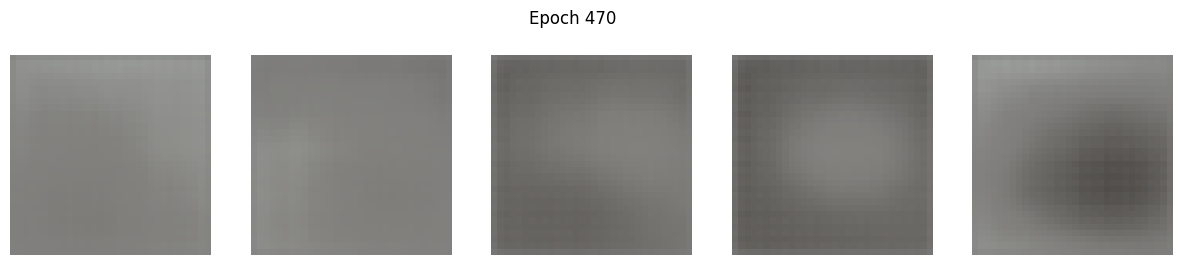

49/49 [==============================] - 6s 113ms/step - loss: 275.3698 - reconstruction_loss: 268.0080 - kl_loss: 7.2657 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 471/500
49/49 [==============================] - 5s 108ms/step - loss: 275.1282 - reconstruction_loss: 268.1427 - kl_loss: 7.2469 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 472/500
49/49 [==============================] - 5s 108ms/step - loss: 275.1012 - reconstruction_loss: 268.3112 - kl_loss: 7.2302 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 473/500
49/49 [==============================] - 5s 107ms/step - loss: 276.4344 - reconstruction_loss: 268.5848 - kl_loss: 7.2148 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 474/500
49/49 [==============================] - 5s 107ms/step - loss: 275.9985 - reconstruc

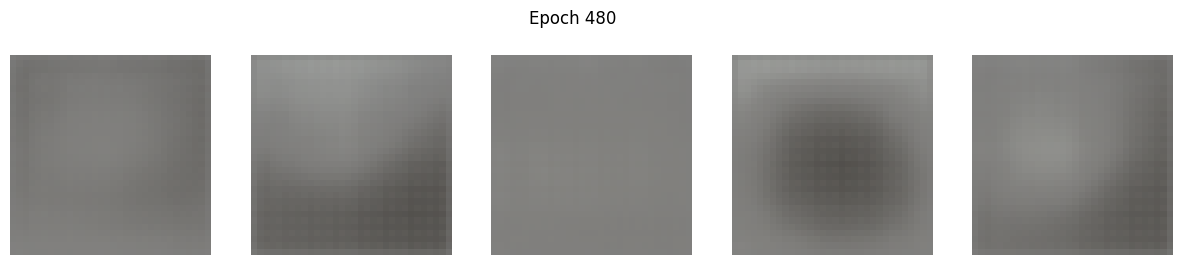

49/49 [==============================] - 6s 120ms/step - loss: 276.7460 - reconstruction_loss: 269.9034 - kl_loss: 7.1350 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 481/500
49/49 [==============================] - 5s 107ms/step - loss: 277.5636 - reconstruction_loss: 270.0389 - kl_loss: 7.1123 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 482/500
49/49 [==============================] - 5s 107ms/step - loss: 277.1612 - reconstruction_loss: 270.2184 - kl_loss: 7.1069 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 483/500
49/49 [==============================] - 5s 108ms/step - loss: 277.7854 - reconstruction_loss: 270.4176 - kl_loss: 7.0770 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 484/500
49/49 [==============================] - 5s 108ms/step - loss: 277.9310 - reconstruc

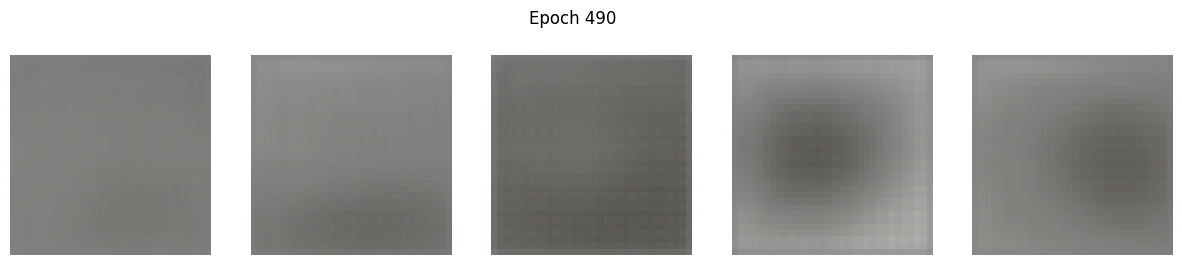

49/49 [==============================] - 5s 112ms/step - loss: 278.9510 - reconstruction_loss: 271.7775 - kl_loss: 6.9813 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 491/500
49/49 [==============================] - 5s 108ms/step - loss: 278.3234 - reconstruction_loss: 271.9800 - kl_loss: 6.9680 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 492/500
49/49 [==============================] - 5s 110ms/step - loss: 278.6829 - reconstruction_loss: 272.1043 - kl_loss: 6.9545 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 493/500
49/49 [==============================] - 5s 108ms/step - loss: 279.0365 - reconstruction_loss: 272.4005 - kl_loss: 6.9386 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 494/500
49/49 [==============================] - 5s 108ms/step - loss: 279.6341 - reconstruc

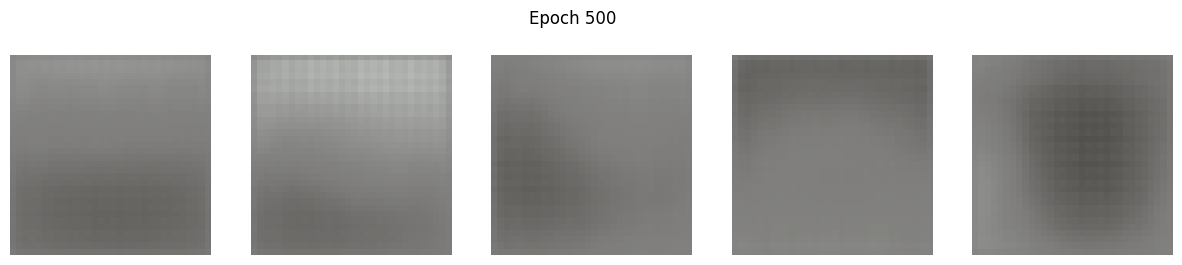

49/49 [==============================] - 5s 112ms/step - loss: 280.3744 - reconstruction_loss: 273.7021 - kl_loss: 6.8585 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00


In [108]:
########################################
# 5. Навчання
########################################
# Оскільки це автоенкодер, часто в якості "міток" для fit() подають ті ж x_train.
# Так само для валідації: (x_test, x_test).
# Якщо не хочете валідації, можна не вказувати або поставити None.
########################################
history = vae_model.fit(
    x_train, x_train,
    epochs=500,            
    batch_size=1024,
    validation_data=(x_test, x_test),
    callbacks=[GenerateImagesCallback(vae_model, latent_dim=latent_dim, interval=10, n_images=5)]
)


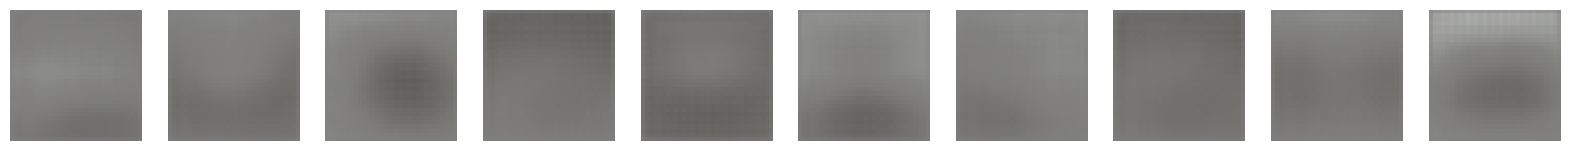

In [109]:
# Кількість зображень для генерації
n_to_generate = 10

# Генеруємо випадкові точки з Normal(0, 1)
z_sample = tf.random.normal(shape=(n_to_generate, latent_dim))

# Пропускаємо через декодер
generated_images = vae_model.decoder(z_sample)


# Функція для візуалізації
def plot_images(images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()


# Виведемо результат
plot_images(generated_images.numpy(), n=n_to_generate)

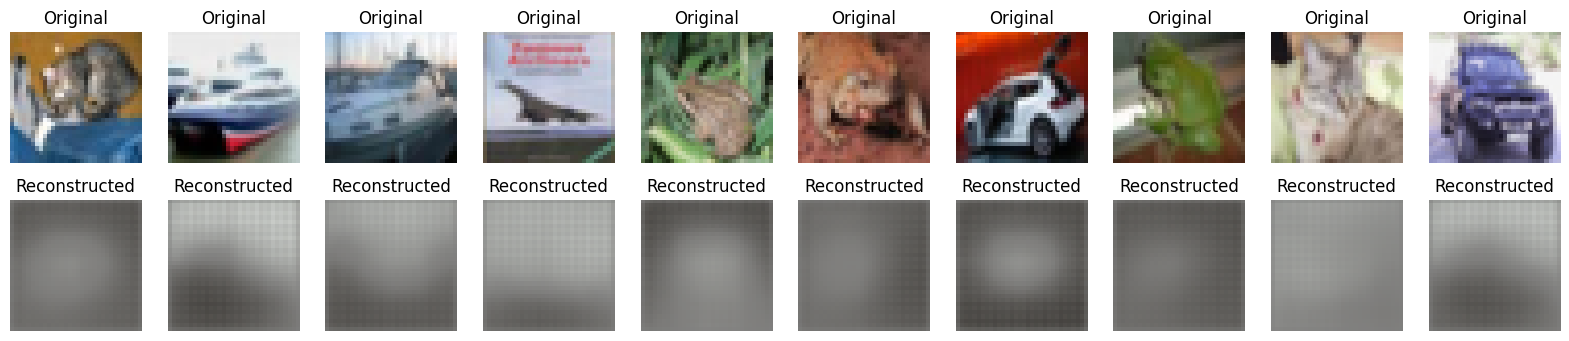

In [110]:
# Беремо перші 10 зображень з тесту
x_test_subset = x_test[:10]
mu, logvar, z = encoder(x_test_subset)
x_test_reconstructed = decoder(z)


# Відображаємо оригінали та реконструкції поруч
def plot_original_vs_recon(original, reconstructed):
    n = len(original)
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Оригінали
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis("off")

        # Реконструкція
        ax = plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()


plot_original_vs_recon(x_test_subset, x_test_reconstructed.numpy())

### STEP 5

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import numpy as np

/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/yuri/.pyenv/versions/3.10.13/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.18.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do no

ModuleNotFoundError: No module named 'keras.src.engine'

In [ ]:
# Hyperparameters
num_filters_encoder = [128, 256, 512, 512, 512]
num_filters_decoder = [512, 512, 512, 256, 128]
latent_dim = 1024

In [ ]:
# Load and preprocess data
(x_train, _), (x_test, _) = keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [ ]:
# Residual Block
class ResidualBlock(layers.Layer):
    def __init__(self, filters):
        super(ResidualBlock, self).__init__()
        self.conv1 = layers.Conv2D(filters, 3, padding="same")
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(filters, 3, padding="same")
        self.bn2 = layers.BatchNormalization()

    def call(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        return tf.nn.relu(x)

In [ ]:
# Attention Block
class AttentionBlock(layers.Layer):
    def __init__(self, filters):
        super(AttentionBlock, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=4, key_dim=filters // 4)
        self.ln = layers.LayerNormalization()

    def call(self, x):
        shape = tf.shape(x)
        height, width = shape[1], shape[2]
        x_reshaped = tf.reshape(x, [-1, height * width, shape[-1]])
        attention_output = self.mha(x_reshaped, x_reshaped)
        attention_output = tf.reshape(attention_output, [-1, height, width, shape[-1]])
        return self.ln(x + attention_output)

In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, 3, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

for filters in num_filters_encoder:
    x = ResidualBlock(filters)(x)
    x = layers.Conv2D(filters, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if filters >= 256:
        x = AttentionBlock(filters)(x)
    x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(2048, activation="relu")(x)
x = layers.Dropout(0.5)(x)

mu = layers.Dense(latent_dim, name="mu")(x)
logvar = layers.Dense(latent_dim, name="logvar")(x)


def sampling(args):
    mu, logvar = args
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * logvar) * epsilon


z = layers.Lambda(sampling, name="z")([mu, logvar])
encoder = keras.Model(encoder_inputs, [mu, logvar, z], name="encoder")

In [ ]:
# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(1 * 1 * num_filters_decoder[0], activation="relu")(latent_inputs)
x = layers.Reshape((1, 1, num_filters_decoder[0]))(x)

for filters in num_filters_decoder:
    x = ResidualBlock(filters)(x)
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    if filters >= 256:
        x = AttentionBlock(filters)(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same", activation="sigmoid")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
# Improved VAE
class ImprovedVAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(ImprovedVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

        vgg = keras.applications.VGG16(include_top=False, weights="imagenet")
        self.perceptual_model = keras.Model(
            vgg.input, vgg.get_layer("block3_conv3").output
        )
        self.perceptual_model.trainable = False

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.perceptual_loss_tracker = keras.metrics.Mean(name="perceptual_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.perceptual_loss_tracker,
        ]

    def compute_perceptual_loss(self, real, generated):
        real = tf.image.resize(real, (224, 224))
        generated = tf.image.resize(generated, (224, 224))
        real_features = self.perceptual_model(real)
        gen_features = self.perceptual_model(generated)
        return tf.reduce_mean(tf.square(real_features - gen_features))

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            mu, logvar, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            perceptual_loss = self.compute_perceptual_loss(data, reconstruction)

            kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))

            tv_loss = tf.reduce_mean(tf.image.total_variation(reconstruction))

            total_loss = (
                reconstruction_loss
                + self.beta * kl_loss
                + 0.1 * perceptual_loss
                + 0.01 * tv_loss
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        grads = [tf.clip_by_norm(g, 1.0) for g in grads]
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.perceptual_loss_tracker.update_state(perceptual_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "perceptual_loss": self.perceptual_loss_tracker.result(),
        }

In [ ]:
# Training setup
initial_learning_rate = 1e-4
warmup_steps = 1000
decay_steps = 10000

lr_schedule = keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate, decay_steps, t_mul=2.0, m_mul=0.9, alpha=1e-6
)

optimizer = tfa.optimizers.AdamW(
    learning_rate=lr_schedule, weight_decay=1e-4, amsgrad=True
)

vae_model = ImprovedVAE(encoder, decoder, beta=0.1)
vae_model.compile(optimizer=optimizer)

In [ ]:
# Callback for image generation
class GenerateImagesCallback(keras.callbacks.Callback):
    def __init__(self, model, latent_dim=512, interval=10, n_images=5):
        super().__init__()
        self.model = model
        self.latent_dim = latent_dim
        self.interval = interval
        self.n_images = n_images

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            z_random = tf.random.normal(shape=(self.n_images, self.latent_dim))
            generated_images = self.model.decoder(z_random)

            plt.figure(figsize=(15, 3))
            for i in range(self.n_images):
                plt.subplot(1, self.n_images, i + 1)
                plt.imshow(generated_images[i])
                plt.axis("off")
            plt.suptitle(f"Epoch {epoch+1}")
            plt.show()

In [ ]:
# Training
history = vae_model.fit(
    x_train,
    epochs=100,
    batch_size=128,
    validation_data=x_test,
    callbacks=[
        GenerateImagesCallback(
            vae_model, latent_dim=latent_dim, interval=10, n_images=5
        )
    ],
)